Efe Baslar
- Berlin School of Economics PhD Student
- BSE Matriculation Number: 205284
- e-mail: efe.baslar@esmt.org
- as I am not enrolled at HU, I do not know if the BSE matriculation number qualifies as a HU matriculation number.
- please contact me if it does not

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import datetime as dt
from matplotlib import pyplot as plt
import seaborn as sns
import os
import woe_iv as woe
from category_encoders.woe import WOEEncoder
import statsmodels.api as sm 
import shap as sp
import dice_ml as dc
import hyperopt as hp
import alibi as al
import random

from sklearn import cluster 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from skfeature.function.similarity_based import fisher_score


import six
import sys


sys.modules['sklearn.externals.six'] = six

import joblib
sys.modules['sklearn.externals.joblib'] = joblib
sys.modules["sklearn.externals.six.moves"] = six.moves




from costcla.models import BayesMinimumRiskClassifier

#pip install skfeature-chappers
#pip install woe-iv
#pip install graphviz
#pip install category_encoders
#pip install shap
#pip install dice-ml
#pip install alibi
#pip install HYPEROPT


random.seed(1)




The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.


In [5]:
os.chdir("C:/Users/Efe/Desktop/BADS/")
os.getcwd()
#this is my working directory, obviously

'C:\\Users\\Efe\\Desktop\\BADS'

# Introduction

Our task is analysing an e-commerce company´s data on a subset of their order records to construct a model to predict item returns to give pop-up warnings to the customers, who are about to make a purchase that is likely to be returned to the vendor. Although the reasoning is pretty straightforward, there can be a myriad of underlying factors that determine a return decision. Beside the herculean task of accurately predicting the variable of interest, we must also consider the incurred costs because of a false prediction. If a user is prompted with a warning, urging them not to purchase the item, the vendor faces with an opportunity cost due to the unsold item. On the other hand, a return decision that goes under the radar brings about shipping and other logistical costs on top of the price of the returned item. 

Throughout the analysis I use the following naming convention: no or "1" as the suffix for the known data, 2 as the suffix for the unknown data.

In [6]:
data1 = pd.read_csv("BADS_WS2021_known.csv")
data2 = pd.read_csv("BADS_WS2021_unknown.csv")

First things first, let us see how the data is structured. The data has 14 features, two of which are the binary response variable and the unique identifier for the dataset. This leaves us 12 features to start our analysis with. Two of these features seem to have null values, which will be thoroughly investigated.

In [7]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   order_item_id  100000 non-null  int64  
 1   order_date     100000 non-null  object 
 2   delivery_date  90682 non-null   object 
 3   item_id        100000 non-null  int64  
 4   item_size      100000 non-null  object 
 5   item_color     100000 non-null  object 
 6   brand_id       100000 non-null  int64  
 7   item_price     100000 non-null  float64
 8   user_id        100000 non-null  int64  
 9   user_title     100000 non-null  object 
 10  user_dob       91275 non-null   object 
 11  user_state     100000 non-null  object 
 12  user_reg_date  100000 non-null  object 
 13  return         100000 non-null  int64  
dtypes: float64(1), int64(5), object(8)
memory usage: 10.7+ MB


The unique identifier ("order_item_id") of the known part is not going to the necessary for the remainder of the analysis. I am only keeping the IDs from the unknown part as a different variable, since they will be required when constructing the prediction file.

In [8]:
order_id_unknown = data2["order_item_id"]

data1 = data1.drop("order_item_id",axis=1)
data2 = data2.drop("order_item_id",axis=1)

Some of the analyses below necessitates the features to be converted to the string type. The cell below serves this purpose.

In [9]:
objvars = data1.select_dtypes(include="object").columns
data1[objvars] = data1[objvars].astype(str)

There are several date/time features and these are kept in an incorrect format, impeding further analysis. I change the feature types to take full advantage of the date/time toolkit available to us.

I apply the necessary transformation to both datasets. Suppresing the errors due to some NA´s in some of the features. We´ll discover that some of the missing values actually carry significant predictive power.

In [10]:
timevars = ["order_date","delivery_date","user_dob","user_reg_date"]
#name of the data/time features are written are stored in the timevars variable, after eyeballing the dataset.
suffix = "_formatted" 

timevars_new = []
for i in timevars:
    timevars_new.append(i + suffix)  #new date/time feature names




#applying the to_datetime function across the chosen variables
data1[timevars_new] = data1[timevars].apply(axis=1, func=lambda x : pd.to_datetime(x,errors="coerce")) 
data2[timevars_new] = data2[timevars].apply(axis=1, func=lambda x : pd.to_datetime(x,errors="coerce"))

In [11]:
orders_date = data1.groupby("order_date").agg({"order_date":"size","return":"sum"}).rename(columns={"order_date":"order_day"}).reset_index()
orders_date["ratio"] = orders_date["return"]/orders_date["order_day"]
orders_date["order_date"] = pd.to_datetime(orders_date["order_date"])
orders_date["non_return"] = orders_date["order_day"] - orders_date["return"]

#sns.lineplot(data=orders_date,x="order_date",y="ratio")

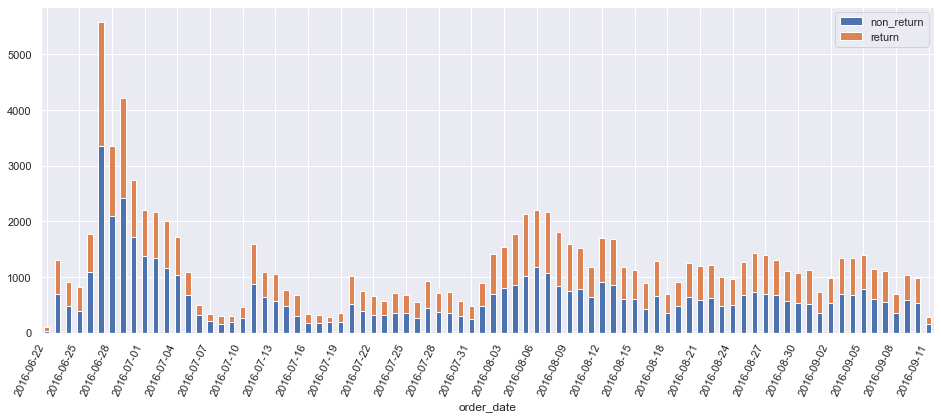

In [12]:
sns.set()

fig, ax = plt.subplots(figsize = (16,6)) 


fig = orders_date.plot(x="order_date",y=["non_return","return"],kind="bar",stacked=True,ax=ax)


indices = list(np.arange(0,orders_date.shape[0],3))
ax.set_xticks(indices)
ax.set_xticklabels(orders_date.loc[indices,"order_date"].astype(str),rotation=65, ha='right')


plt.show()

The figure above shows the temporal distribution of the purchases and returned items. There seems to be a major surge in incoming orders in late June/early July. But this storm subsides as July progresses. In August the purchases seem to pick up their pace and keep that level until the end of the time period covered by the unknown dataset.

Some features are better kept as caterogical types due to the nature of analysis they will undergo.

In [13]:
catvars = ["item_id","item_color","brand_id","user_id","user_title","user_state"]
data1[catvars] = data1[catvars].astype("category")
data2[catvars] = data2[catvars].astype("category")

# EDA and Data Preparation

## Item-specific features


Now to start with some analysis. It is intuitive to assume that some items may be more likely to be returned than others.  Let us focus on the column "item_id":

In [14]:
items = data1.groupby("item_id").agg({"item_id":"size","return":"sum"}).rename(columns={"item_id":"itemCount"}).reset_index()
#pandas groupby function aggregates the known dataset with respect to the item identifiers, to calculate the corresponding return evidence for each item.
items["itemRatio"] = items["return"]/items["itemCount"]


It is worth noting that if an item occurs more frequently in the dataset, it can be argued that the evidence shown by the return rates is stronger. Therefore, it is a good idea to include clusters of items with respect to their posterior return probabilities and the times they were ordered. Expecting that, the weakness of the evidence will not be detrimental to the prediction quality in the end.

Speaking of clustering analysis, scaling the dimensions into [0,1] is good practice. Because probabilities are already scaled in this interval it is not necessary to conduct the operation on that column. The number of orders, however, requires the transformation.

In [15]:
def scaling(x):
    return (x - np.min(x))/(np.max(x)-np.min(x))

It is worth taking a look at the distribution of the orders, as it is a feature that has just been created:

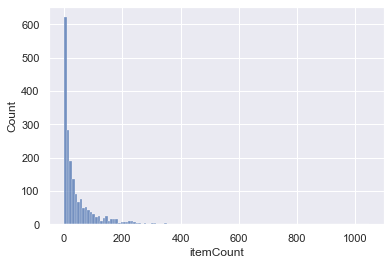

In [16]:
sns.set_theme()
sns.histplot(items["itemCount"])
plt.show()

This is a typical occasion of a right skewed distribution (that of a possibly following a poisson distribution). Taking the natural logarithm of this is going the help us get rid of the skewness.

In [17]:
items["item_count_scaled"] = scaling(np.log(items["itemCount"]))

Let us try to find the optimal number of clusters:

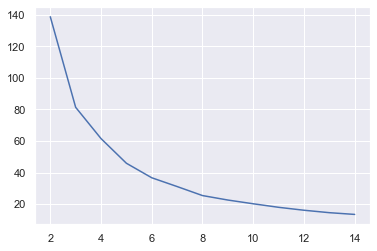

In [18]:
ssArray = []

#ssArray stores the error metric for each clustering attempt to plot them.
for i in range(2,15):
    ssArray.append(cluster.k_means(items[["item_count_scaled","itemRatio"]],n_clusters=i)[2])
    
sns.lineplot(x=range(2,15),y=ssArray)
plt.show()

While there seems to be a kink at n=3, there are more minor kinks at n=6 and n=8. I choose using 8 as the number of clusters. Because it gives a better division of the itemRatio-itemCount space.

In [19]:
itemsKmeans = cluster.k_means(items[["item_count_scaled","itemRatio"]],n_clusters=8)
items["itemCluster"] = itemsKmeans[1]

Let us see how the clusters look:

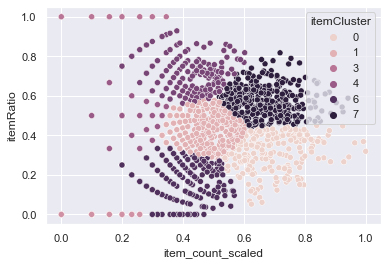

In [20]:
sns.scatterplot(x="item_count_scaled",y="itemRatio",hue="itemCluster",data=items)
plt.show()

I must say that the visual looks a bit suspicious. While it can indeed give us better predictions if investigated deep enough, I believe it defeats the purpose of this assignment and I will not be insvestigating this specific phenomenon any further. However, the results give us some insights that can be useful. The cluster roughly divides the item ratio / item count space to combinations of high and low values of these features. 

Focusing back to the item-specific return rates, 
After all the attempts at predictions, I have found it especially beneficial to include a threshold by which I filter the evidence with insufficient observations. For these observations, I find it reasonable to assign a ratio of 0.5 which is equivalent to saying "I do not know" in this context. 

Take an item that has only been bought once for instance, it is going to have either 0 or 1 as the return ratio. This will without a doubt cause overfitting issues. 

In [21]:
items["itemCheck"] = items["itemCount"] > 4 #the boolean itemCheck feature shows the "strong-evidence" entries.
items.loc[~items["itemCheck"],"itemRatio"] = 0.5 #

Now we can carry the results of the minor analysis we have conducted on item_id to the main data sets.

In [22]:
data1 = data1.merge(items[["item_id","itemCluster","itemRatio","itemCheck","item_count_scaled"]],how="left",on="item_id") 
data1

#the good old left join operation.

,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,user_dob,...,user_reg_date,return,order_date_formatted,delivery_date_formatted,user_dob_formatted,user_reg_date_formatted,itemCluster,itemRatio,itemCheck,item_count_scaled
0,2016-06-22,2016-06-27,643,38,navy,30,49.90,30822,Mrs,1969-04-17,...,2016-06-23,0,2016-06-22,2016-06-27,1969-04-17,2016-06-23,6,0.181818,True,0.444580
1,2016-06-22,nan,337,152,grey,30,19.95,30822,Mrs,1969-04-17,...,2016-06-23,0,2016-06-22,NaT,1969-04-17,2016-06-23,6,0.096154,True,0.568301
2,2016-06-22,2016-06-27,270,xxl,grey,49,79.90,30823,Mrs,1970-04-22,...,2015-03-15,1,2016-06-22,2016-06-27,1970-04-22,2015-03-15,7,0.506173,True,0.632047
3,2016-06-22,2016-06-27,142,xxl,grey,49,99.90,30823,Mrs,1970-04-22,...,2015-03-15,0,2016-06-22,2016-06-27,1970-04-22,2015-03-15,7,0.535088,True,0.780894
4,2016-06-22,2016-06-27,561,xxl,grey,3,14.90,30823,Mrs,1970-04-22,...,2015-03-15,1,2016-06-22,2016-06-27,1970-04-22,2015-03-15,0,0.386861,True,0.707633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2016-09-11,2016-09-12,156,20,blue,34,29.90,713,Mrs,1959-03-21,...,2015-02-17,0,2016-09-11,2016-09-12,1959-03-21,2015-02-17,7,0.502262,True,0.776409
99996,2016-09-11,2016-09-12,156,20,brown,34,29.90,713,Mrs,1959-03-21,...,2015-02-17,0,2016-09-11,2016-09-12,1959-03-21,2015-02-17,7,0.502262,True,0.776409
99997,2016-09-11,1994-12-31,1832,xxl,black,37,26.90,47794,Mr,1985-03-01,...,2016-09-10,0,2016-09-11,1994-12-31,1985-03-01,2016-09-10,7,0.448980,True,0.659449
99998,2016-09-11,1994-12-31,1832,xxl,black,37,26.90,47794,Mr,1985-03-01,...,2016-09-10,0,2016-09-11,1994-12-31,1985-03-01,2016-09-10,7,0.448980,True,0.659449


It is useful to take a look at the distribution of the scaled item occurance feature, because we are going to require a similar distribution of these values when we apply the same transformations on the unknown dataset (data2).

<AxesSubplot:xlabel='item_count_scaled', ylabel='Count'>

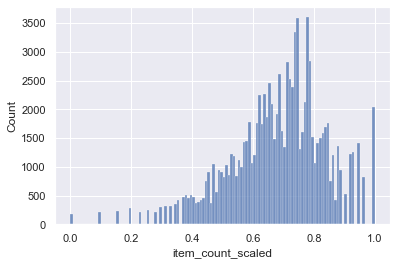

In [23]:
sns.histplot(data1["item_count_scaled"])

The histogram above is to be compared to the second histogram from the unknown dataset, just below.

Some items appear both in the known and the unknown datasets. It is safe to assume that they are the same items and they will be carrying over their tendency to be returned to the unknown dataset. 

In [24]:
data2 = data2.merge(items[["item_id","itemCluster","itemRatio","itemCheck","itemCount"]],how="left",on="item_id")

#left joining the unknown data with the "items" dataset. bringing the information over from the known dataset.

Of course, some items are unique to the unknown dataset. We do not know anything about these items because we cannot observe anything about them within the scope of the known dataset, so I will be adding the naive/neutral [0.5] value for those observations. After the merging operation I have just done above, the observations unique to the unknown dataset get a [NA] for the features of interest. 

In [25]:
data2.itemRatio.fillna(0.5,inplace=True) 
data2.itemCount.fillna(0,inplace=True)
data2.itemCheck.fillna(False,inplace=True) 

Because the unknown dataset is merely a continuation of the known dataset, therefore the item counts should follow that as well. Thus, I add the item counts from the known part of the data on top of the item counts exclusive to the unknown data.

In [26]:
items2 = data2.groupby("item_id").agg(itemCount2=("item_id","count")) #aggregate the unknown dataset to compute the item frequencies

In [27]:
data2 = data2.merge(items2,how="left",on="item_id") # join the unknown dataset with the associated items dataframe.

In [28]:
data2.itemCount = data2.itemCount + data2.itemCount2 #known + unknown



The histogram below shows that the popularity distribution of the items in the unknown dataset is comparable to the known dataset. Which leads us to conclude that there is no imminent danger to using this feature. The logarithm transformation is applied here again, to ensure this.

<AxesSubplot:xlabel='item_count_scaled', ylabel='Count'>

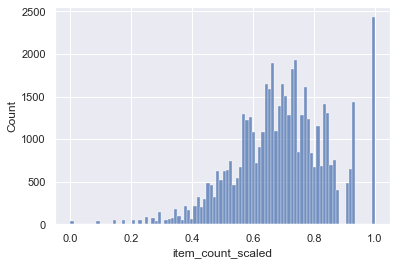

In [29]:
data2["item_count_scaled"] = scaling(np.log(data2.itemCount))
sns.histplot(data2["item_count_scaled"])

## Brand Ratio

The brand to which the offered item belongs, may also play a role in the return decision, as some brands might be notoriously bad/quite successful at communicating the properties of their products.

In [30]:
brands = data1.groupby("brand_id").agg({"brand_id":"size","return":"sum"}).rename(columns={"brand_id":"brandCount"}).reset_index()
brands["brandRatio"] = brands["return"]/brands["brandCount"]

brands["brandCheck"] = brands["brandCount"] > 5
brands.loc[~brands["brandCheck"],"brandRatio"] = 0.5

data1 = data1.merge(brands[["brand_id","brandRatio"]],how="left",on="brand_id")
data2 = data2.merge(brands[["brand_id","brandRatio"]],how="left",on="brand_id")

data2.brandRatio.fillna(0.5,inplace=True)


Now let us move to another item-related feature:

## An interplay between items and customers

If a certain user is ordering a specific item for the first time, their expectations might not meet the reality. This might be influential on the eventual return decision. Let us investigate that. I attempted to group by these three distinct variables as I normally do on R, but it did not have the same effect in python and actually tried to allocate an impossible amount of RAM. Instead, I concetanate the aforementioned variables into one, and pivot based on that. This is a recurring strategy throughout the notebook.

The aim is to get a list of all the combinations of users, items and order dates. Therefore we will be able to tell the first time when a specific user buys a specific item.

In [31]:
data1["key"] = data1["user_id"].astype(str) + "&" + data1["item_id"].astype(str) + "&" + data1["order_date"] #using the python concatenate operator

userItem = data1.groupby("key").agg(count=("key","size")).reset_index() #the key column is unique in this context. 


In [32]:
#necessary manipulations 

varHolder = userItem["key"].apply(func = lambda x: x.split("&")) #splitting the key back to its core components. The result is an array of lists.

varNames = ["user_id","item_id","order_date"] #we want the columns named like this

for i in range(len(varNames)):
    userItem[varNames[i]] = varHolder.apply(lambda x: x[i]) #after the split, each element of the ensuing array has exactly the same number of sub-elements. In this case, 3 of them.
  
userItem["order_date_formatted"] = pd.to_datetime(userItem["order_date"],errors="coerce") #we need this formatted as a date/time variable to find the first occurence.

userItem.sort_values("user_id") #just to display what we have now

,key,count,user_id,item_id,order_date,order_date_formatted
0,1000&707&2016-06-28,2,1000,707,2016-06-28,2016-06-28
14,10005&683&2016-06-27,1,10005,683,2016-06-27,2016-06-27
13,10005&671&2016-08-24,1,10005,671,2016-08-24,2016-08-24
12,10005&660&2016-08-24,1,10005,660,2016-08-24,2016-08-24
10,10005&465&2016-08-24,1,10005,465,2016-08-24,2016-08-24
...,...,...,...,...,...,...
81542,999&434&2016-09-09,1,999,434,2016-09-09,2016-09-09
81543,9992&146&2016-07-10,1,9992,146,2016-07-10,2016-07-10
81544,9992&32&2016-07-10,2,9992,32,2016-07-10,2016-07-10
81545,9995&1332&2016-07-31,1,9995,1332,2016-07-31,2016-07-31


We need another layer of analysis to get what we want. The new key "key2" stores the user-item combinations. Because the order_date variable captures all the occurences that specific combination took place, will be able to find the first time that combination was observed.

In [33]:
userItem["key2"] = userItem["user_id"].astype(str) + "&" + userItem["item_id"].astype(str) #concatenating for the required variable, again


temp = userItem.groupby("key2").agg(thisFirst=("order_date_formatted","min")).reset_index() #temp df stores the first time the item-user combination occurs.
userItem = userItem.merge(temp,how="left",on="key2") # we need to merge this back to the upper layer.
userItem["isFirstPurchase"] = userItem["thisFirst"] == userItem["order_date_formatted"] #so that we can compare the order date to the first order date.
userItem #let´s have a look at it to see if it works


,key,count,user_id,item_id,order_date,order_date_formatted,key2,thisFirst,isFirstPurchase
0,1000&707&2016-06-28,2,1000,707,2016-06-28,2016-06-28,1000&707,2016-06-28,True
1,10005&118&2016-06-27,1,10005,118,2016-06-27,2016-06-27,10005&118,2016-06-27,True
2,10005&135&2016-06-27,2,10005,135,2016-06-27,2016-06-27,10005&135,2016-06-27,True
3,10005&215&2016-06-27,1,10005,215,2016-06-27,2016-06-27,10005&215,2016-06-27,True
4,10005&258&2016-06-27,2,10005,258,2016-06-27,2016-06-27,10005&258,2016-06-27,True
...,...,...,...,...,...,...,...,...,...
81542,999&434&2016-09-09,1,999,434,2016-09-09,2016-09-09,999&434,2016-09-09,True
81543,9992&146&2016-07-10,1,9992,146,2016-07-10,2016-07-10,9992&146,2016-07-10,True
81544,9992&32&2016-07-10,2,9992,32,2016-07-10,2016-07-10,9992&32,2016-07-10,True
81545,9995&1332&2016-07-31,1,9995,1332,2016-07-31,2016-07-31,9995&1332,2016-07-31,True


In [34]:
data1 = data1.merge(userItem[["key","isFirstPurchase"]],how="left",on="key")
#merge-ception ends here as we can finally carry our results to the known dataset.


In [35]:
pd.crosstab(data1["isFirstPurchase"],data1["return"]).apply(lambda x: x/sum(x),axis=1) 
#let us see how return rates change if the user orders a specific item for the first time

return,0,1
isFirstPurchase,,
False,0.622731,0.377269
True,0.535578,0.464422


A user´s first purchase of an item seems to have increased odds for a return, albeit not dramatic this seems to be a statistically significant difference that can have some predictive power.

Again, we need to apply the same transformation on the unknown dataset. So, if a user-item combination in unknown dataset is already present in the known dataset, then it is not a first purchase. However, it is possible that some users buy an item for the first time, during the time covered by the unknown dataset (New users, new items and/or new combinations).

In [36]:


data2["key2"] = data2["user_id"].astype(str) + "&" + data2["item_id"].astype(str)

#the line below checks if a combination in the unknown dataset has already appeared in the known dataset
#if it has appeared we can carry over the first purchase information.
prevComb = data2["key2"].isin(userItem["key2"])

data2["key"] = data2["user_id"].astype(str) + "&" + data2["item_id"].astype(str) + "&" + data2["order_date"]

userItem2 = data2.loc[~prevComb,:].groupby("key").agg(count=("key","size")).reset_index() #making the same operations on the new combinations

varHolder2 = userItem2["key"].apply(func = lambda x: x.split("&"))


for i in range(len(varNames)):
    userItem2[varNames[i]] = varHolder2.apply(lambda x: x[i])

userItem2["order_date_formatted"] = pd.to_datetime(userItem2["order_date"],errors="coerce")


In [37]:

userItem2["key2"] = userItem2["user_id"].astype(str) + "&" + userItem2["item_id"].astype(str)

temp = userItem2.groupby("key2").agg(thisFirst=("order_date_formatted","min")).reset_index()

userItem2 = userItem2.merge(temp,how="left",on="key2")
userItem2["isFirstPurchase"] = userItem2["thisFirst"] == userItem2["order_date_formatted"]

userItem2 #combinations that were not seen in the known dataset

,key,count,user_id,item_id,order_date,order_date_formatted,key2,thisFirst,isFirstPurchase
0,10005&1444&2016-12-08,2,10005,1444,2016-12-08,2016-12-08,10005&1444,2016-12-08,True
1,10005&1539&2016-12-08,1,10005,1539,2016-12-08,2016-12-08,10005&1539,2016-12-08,True
2,10005&1712&2016-12-08,1,10005,1712,2016-12-08,2016-12-08,10005&1712,2016-12-08,True
3,10005&1722&2016-12-08,1,10005,1722,2016-12-08,2016-12-08,10005&1722,2016-12-08,True
4,10005&2083&2016-12-08,1,10005,2083,2016-12-08,2016-12-08,10005&2083,2016-12-08,True
...,...,...,...,...,...,...,...,...,...
39868,999&57&2016-11-30,2,999,57,2016-11-30,2016-11-30,999&57,2016-11-30,True
39869,9995&1469&2016-12-10,1,9995,1469,2016-12-10,2016-12-10,9995&1469,2016-12-10,True
39870,9999&1401&2016-11-18,3,9999,1401,2016-11-18,2016-11-18,9999&1401,2016-11-18,True
39871,9999&1401&2016-11-22,2,9999,1401,2016-11-22,2016-11-22,9999&1401,2016-11-18,False


In [38]:
data2 = data2.merge(userItem2[["key","isFirstPurchase"]],how="left",on="key")

#if the unknown dataset has not received any information after the merge,
#it means that specific combination appears in the known dataset and therefore it is not a first purchase
data2["isFirstPurchase"].fillna(False,inplace=True) 
#prevCustomer = data2.user_id.isin(data1.user_id) #if the user occurs in the known dataset,
#data2.loc[prevCustomer,"isFirstPurchase"] = False

## Customer-specific features

### Customer Age

The age of the customers and their overall demographics might be effective on the return decision, to an extent. Their overall internet skills, their interest on this specific field of business, their experience with the vendor might have some effect on their purchases being returned or not. 

While it may be the case that, a return takes place because a customer was not satisfied with the purchase, it is also possible that the purchase was a wrong one, perhaps due to clumsiness.

Creating age groups might be a good idea in this direction. I would also like to preserve the likely information (possibly that of a lack of internet-savyness, or of an increased data protection sensitiveness) contained in the absence of age records. Therefore, I will be replacing them with negative values. This is not going to create any issues since the feature is not going to stay ordinal and be transformed into a categorical feature instead.

<AxesSubplot:xlabel='age', ylabel='Count'>

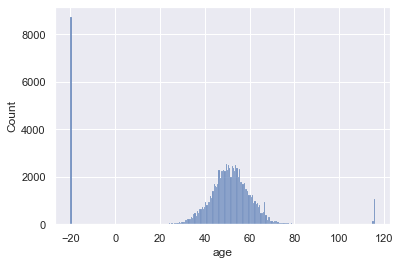

In [39]:
data1["age"] = (data1["order_date_formatted"] - data1["user_dob_formatted"]).dt.days/365 #age in years at the day of the order
data1["age"] = data1["age"].fillna(-20)

sns.histplot(data1["age"])

<AxesSubplot:xlabel='age', ylabel='Count'>

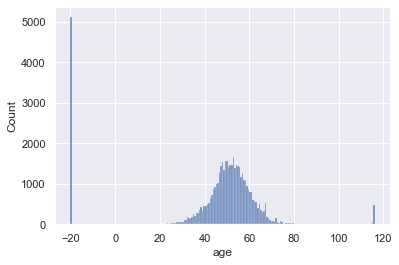

In [40]:
data2["age"] = (data2["order_date_formatted"] - data2["user_dob_formatted"]).dt.days/365
data2["age"] = data2["age"].fillna(-20)

sns.histplot(data2["age"])

Except the potentially erroneous entries, the ages of the customers seems to be nicely normally distributed.

It can be observed that there is a significant number of users who did not register a birth date. And there are others, who probably got their birthday wrong, or did not actually care about it and got one of the earliest birth dates possible (as evidenced by the spike at the right tail of the histogram). Now let us take a look at the optimal number of clusters:

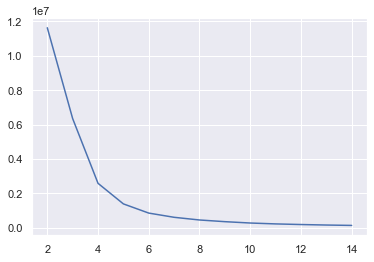

In [41]:
#same strategy as the previous cluster attempt

ssArray = []

for i in range(2,15):
    ssArray.append(cluster.k_means(np.array(data1["age"]).reshape(-1,1),n_clusters=i)[2])
    
sns.lineplot(x=range(2,15),y=ssArray)
plt.show()

There is a major kink at 4, accompanied by several others close-by.

<AxesSubplot:xlabel='age', ylabel='Count'>

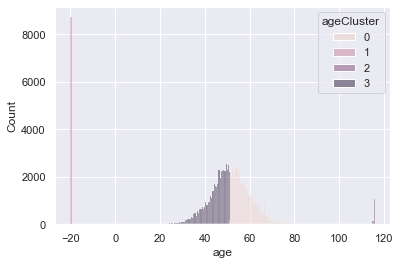

In [42]:
agekMeans = cluster.k_means(np.array(data1["age"]).reshape(-1,1),n_clusters=4)
data1["ageCluster"] = agekMeans[1]

sns.histplot(data=data1,x="age",hue="ageCluster")

Now to do the same transformation for the unknown dataset. Notice that I am using the centroids that belong to the first clustering. Therefore I make sure that they are consistent with each other.

Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.


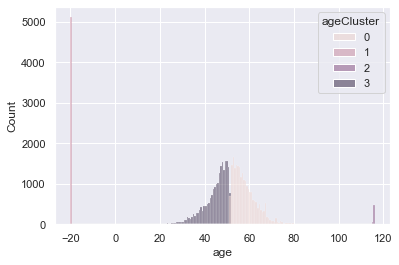

In [43]:
agekMeans2 = cluster.k_means(np.array(data2["age"]).reshape(-1,1),n_clusters=4,init=agekMeans[0])
data2["ageCluster"] = agekMeans2[1]

sns.histplot(data=data2,x="age",hue="ageCluster")
plt.show()


Now that we have 4 clusters, one for missing values, one for extremely high values, and two others, roughly, for the younger and the older customers. If there are any patterns within these values, categorizing them should capture it. Evidence from the known dataset shows us that [45.8%] of all orders are returned. The table below shows us that the customers who did not report a birthday do not actually deviate from the mean. 

But the younger customers and those with an impossibly old birth dates seem to have a slightly higher return rate than the mean.

In [44]:
np.mean(data1["return"])

0.45818

In [45]:
pd.crosstab(data1["ageCluster"],data1["return"]).apply(lambda x: x/sum(x), axis=1)

return,0,1
ageCluster,,
0,0.566708,0.433292
1,0.545185,0.454815
2,0.508407,0.491593
3,0.517195,0.482805


### Customer behavior

How frequently a user purchases from this vendor is also a promising indicator. This could be a proxy for the overall experience and the loyalty of the customer, which could have a positive or a negative effect on item returns.

A very important and promising feature is the average rate of return for each customer. Like I did with the items, I will be using a threshold for eliminating ostensibly weak evidence. Which may cause overfitting, if not addressed.

Among other variables of interest is how big a spender a customer is, which is the average expenditure value associated to that customer.

In [46]:
users = data1.groupby("user_id").agg(userCount=("user_id","size"),totalExpenditure=("item_price","sum"),return1=("return","sum"),first_purchase = ("order_date_formatted","min")).reset_index()
users = users.rename(columns={"return1":"return"})

#similar operations to those I did to get the item features. 
#Aggregating the dataset w.r.t user_id to get the number of occurences and the associated return rates.
users["userRatio"] = users["return"]/users.userCount
users["user_count_scaled"] = scaling(np.log(users["userCount"]))
users["averageExpenditure"] = users["totalExpenditure"]/users["userCount"]
users



,user_id,userCount,totalExpenditure,return,first_purchase,userRatio,user_count_scaled,averageExpenditure
0,9,5,999.50,4,2016-08-01,0.80,0.311618,199.900
1,11,1,44.90,0,2016-07-02,0.00,0.000000,44.900
2,24,1,69.90,0,2016-07-03,0.00,0.000000,69.900
3,30,2,379.80,1,2016-08-13,0.50,0.134206,189.900
4,40,4,499.60,2,2016-08-11,0.50,0.268413,124.900
...,...,...,...,...,...,...,...,...
19200,48237,10,734.25,9,2016-09-11,0.90,0.445824,73.425
19201,48238,2,67.90,1,2016-09-11,0.50,0.134206,33.950
19202,48239,2,209.90,1,2016-09-11,0.50,0.134206,104.950
19203,48240,4,256.60,1,2016-09-11,0.25,0.268413,64.150


There are more unique users in the dataset than there are unique items. This results in more users with weaker evidence, compared to items, because there are much more users with only a few observations.

In [47]:
users["userCheck"] = users["userCount"] > 7 
#the threshold again, a slightly higher threshold seem to perform better for the users



In [48]:
data1 = data1.merge(users[["user_id","userCount","userCheck","userRatio","user_count_scaled","averageExpenditure","first_purchase"]],how="left",on="user_id")
#left join operation to merge the newly created features into the main dataframe
data1.loc[~data1["userCheck"],"userRatio"] = 0.5


After the logarithmic transformation and the following scaling, the skewness in the user counts seem to be remedied.

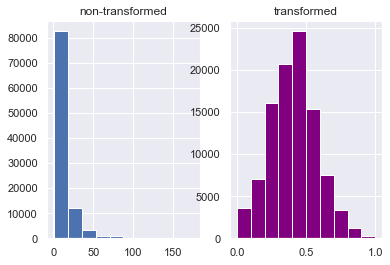

In [49]:

plt.subplot(1,2,1)
plt.hist(data1["userCount"],label="non-transformed")
plt.title("non-transformed")

plt.subplot(1,2,2)
plt.hist(data1["user_count_scaled"],color="purple",label="transformed")
plt.title("transformed")
plt.show()

The unknown dataset needs to undergo the same transformations. The steps I took are again similar to the those when preparing the item-related features.

In [50]:
data2 = data2.merge(users[["user_id","userCount","userCheck","userRatio","averageExpenditure"]],how="left",on="user_id")

In [51]:
#the approach is the same. 
data2.userRatio.fillna(0.5,inplace=True) #if no evidence is available, we "do not know" anything about this.
data2.userCheck.fillna(False,inplace=True)
data2.userCount.fillna(0,inplace=True)



In [52]:
#if an item or a user only appears in the unknown dataset, we do not know anything about their return-related evidence
data2.loc[~data2["itemCheck"],"itemRatio"] = 0.5 
data2.loc[~data2["userCheck"],"userRatio"] = 0.5

In [53]:
users2 = data2.groupby("user_id").agg(userCount2=("user_id","size"),totalExpenditure_2=("item_price","sum")).reset_index() 
#aggregation to get total expenditure and counts
users2 = users2.merge(users[["user_id","userCount","totalExpenditure"]],how="left",on="user_id")
#getting the information from the known dataset to build upon. 

users2["totalExpenditure"].fillna(0,inplace=True) #this variable stores the expenditure in the known dataset
users2["userCount"].fillna(0,inplace=True) # number of purchases in the known dataset

users2["userCount"] = users2["userCount"] + users2["userCount2"] #total number of purchases
users2["totalExpenditure"] = users2["totalExpenditure"] + users2["totalExpenditure_2"] #total amount spent
users2["averageExpenditure"] = users2["totalExpenditure"]/users2["userCount"]

We can see that roughly two thirds of the users in the unknown dataset are new customsers.

In [54]:
print("the number of unique users in the unknown dataset:",users2.shape[0])
print("those who also appeared in the known dataset:",users2.loc[users2["userCount"] != users2["userCount2"],:].shape[0])


the number of unique users in the unknown dataset: 12854
those who also appeared in the known dataset: 4250


In [55]:
del data2["userCount"]
del data2["averageExpenditure"]

data2 = data2.merge(users2[["user_id","userCount","averageExpenditure"]],how="left",on="user_id")

In [56]:
data2["user_count_scaled"] = scaling(np.log(data2["userCount"])) #log transformation followed by scaling of the feature

Text(0.5, 1.0, 'user_count-unknown')

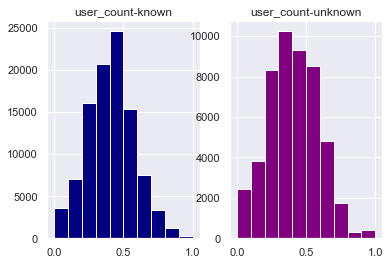

In [57]:
plt.subplot(1,2,1)
plt.hist(data1["user_count_scaled"],color="navy")
plt.title("user_count-known")


plt.subplot(1,2,2)
plt.hist(data2["user_count_scaled"],color="purple")
plt.title("user_count-unknown")


After the transformations, the distributions of the user counts seem to be pretty similar in known and unknown datasets.

### Customer Seniority

Next, continuing to investigate some tendencies of the customers, we can take a peek at the time registered on the vendor´s website. Which, again, be a proxy for customer´s approach towards the vendor. It is also worth noting that some users actually registered with the website after they have ordered an item (Hence, they get a -1 as the customer seniority in days). It may be due to an increased interest or an unobserved customer tendency.

Again, we are going to use a cluster. To make it easier to distinguish the negative value, we are going to replace the -1 with a much smaller value. So that they don't get placed in a wrong cluster.

In [58]:
data1["regAge"] = (data1["order_date_formatted"] - data1["user_reg_date_formatted"]).dt.days #the difference in days
data1.loc[data1.regAge==-1,"regAge"] = -200 #to prevent the -1 value getting mixed up in an unintended category
data2["regAge"] = (data2["order_date_formatted"] - data2["user_reg_date_formatted"]).dt.days
data2.loc[data2.regAge < 0,"regAge"] = -200

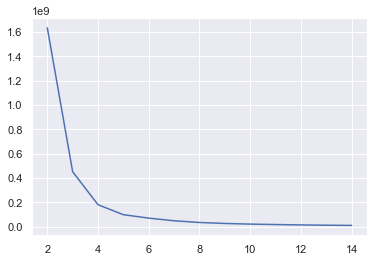

In [59]:
ssArray = [] #the same strategy to discover the kinks

for i in range(2,15):
    ssArray.append(cluster.k_means(np.array(data1["regAge"]).reshape(-1,1),n_clusters=i)[2])
    
sns.lineplot(x=range(2,15),y=ssArray)
plt.show()



<AxesSubplot:xlabel='regAge', ylabel='Count'>

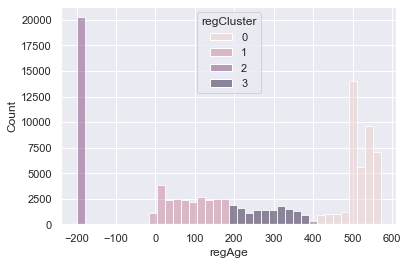

In [60]:
regkMeans = cluster.k_means(np.array(data1["regAge"]).reshape(-1,1),n_clusters=4)
data1["regCluster"] = regkMeans[1]

sns.histplot(data=data1,x="regAge",hue="regCluster")

There seem to be more than 20000 users who registered the day after they ordered an item. Except these users, most users seem to be registered for more than 500 days

In [61]:
pd.crosstab(data1["regCluster"],data1["return"]).apply(lambda x: x/sum(x),axis=1)

return,0,1
regCluster,,
0,0.526681,0.473319
1,0.558510,0.441490
2,0.554727,0.445273
3,0.538529,0.461471


Even though the difference is not very large, more senior users appear to have a slightly higher tendency to return

In [62]:
regkMeans2 = cluster.k_means(np.array(data2["regAge"]).reshape(-1,1),n_clusters=4,init=regkMeans[0]) 
#use the centroids from the cluster on the known dataset
data2["regCluster"] = regkMeans2[1]



Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.


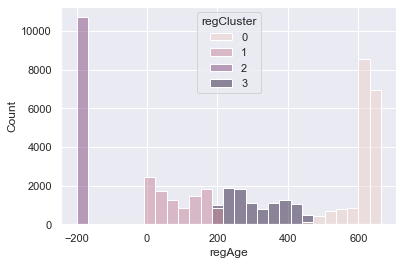

In [63]:
sns.histplot(data=data2,x="regAge",hue="regCluster")
plt.show()

The histograms above show that, the seniority of the users in the unknown dataset is distributed similarly to the seniority of the users in the known dataset. 

In [64]:
pd.concat([pd.crosstab(data1["user_title"],data1["return"]).apply(lambda x: x/sum(x),axis=1),pd.crosstab(data1["user_title"],data1["return"]).apply(lambda x: sum(x),axis=1)],axis=1)

,0,1,0
user_title,,,
Company,0.375000,0.625000,128
Family,0.603865,0.396135,414
Mr,0.576756,0.423244,3915
Mrs,0.540192,0.459808,95429
not reported,0.666667,0.333333,114


Majority (around 95%) of the customers of this vendor are women and their rates of return are pretty close to the general average (No surprises here). Men seem to have a slightly lower tendency to return their items. The rest of the entries are too few in number to make any reliable inference from.

## Miscallenous item properties

Next, we are going to occupy ourselves with the size variable that is present in the dataset. This is an interesting variable, because it contains both numerical and categorical values. What we are going to do is simple, we are just going to seperate these into two different columns. With some help from basic regular expressions, the operations are not that complicated.

In [65]:
sizeDetect = data1.item_size.str.contains("[0-9]") #regex to detect the entries with numerical values
sizeHolder = data1.item_size.str.replace("[+]","") #just to make it easier, assume 40 and 40+ etc. are the same.

data1["size_numeric"] = 0
data1.loc[sizeDetect,"size_numeric"] = sizeHolder[sizeDetect].astype("int") #if the size entries not numerical
data1["size_categoric"] = ""
data1.loc[~sizeDetect,"size_categoric"] = sizeHolder[~sizeDetect] #if the size entries are not numerical

data1["size_categoric"] = data1["size_categoric"].astype("category") #categoric entries typed to category




In [66]:
pd.concat([pd.crosstab(data1["size_categoric"],data1["return"]).apply(lambda x: x/sum(x),axis=1),pd.crosstab(data1["size_categoric"],data1["return"])],axis=1)

return,0,1,0,1
size_categoric,,,,
,0.515894,0.484106,24879,23346
l,0.547096,0.452904,6755,5592
m,0.540236,0.459764,5505,4685
s,0.531021,0.468979,2097,1852
unsized,0.723148,0.276852,3777,1446
xl,0.544312,0.455688,5976,5003
xs,0.600000,0.400000,21,14
xxl,0.570154,0.429846,5112,3854
xxxl,0.697674,0.302326,60,26


It seems there are some some minor differences in return rates among different categories. While some sizes were very rarely ordered, unsized items are significantly underreturned. That is possibly because they are just hats, accessories etc. The blank category represents the items with numerical size feature. The blank value represents the item size with ordinal values, aggregated.

In the unknown dataset, however, these categories are sometimes presented with uppercase letters. Because it is not possible to find out if this change holds any information, I elected to convert them to lowercase. 

In [67]:
#the same transformations on the unknown dataset

sizeDetect2 = data2.item_size.str.contains("[0-9]")
sizeHolder2 = data2.item_size.str.replace("[+]","")

data2["size_numeric"] = 0
data2.loc[sizeDetect2,"size_numeric"] = sizeHolder2[sizeDetect2].astype("int")
data2["size_categoric"] = ""
data2.loc[~sizeDetect2,"size_categoric"] = sizeHolder2[~sizeDetect2]

In [68]:
data2["size_categoric"].value_counts() #some categories appear in lowercase, others in uppercase. 

           22917
unsized     4049
L           3391
l           2910
XL          2839
M           2714
xl          2548
m           2426
XXL         2254
xxl         1944
S           1012
s            921
XXXL          52
XS            11
xs             7
xxxl           5
Name: size_categoric, dtype: int64

In [69]:
data2["size_categoric"] = data2["size_categoric"].str.lower() #all to lowercase
data2["size_categoric"].value_counts() #no significant differences between the known and the unknown dataset

           22917
l           6301
xl          5387
m           5140
xxl         4198
unsized     4049
s           1933
xxxl          57
xs            18
Name: size_categoric, dtype: int64

## Basket size and multiple purchases of the same item

One of the useful features constructed for this prediction task has been related to the "item baskets". By "item basket" I refer to the items a user buys on the same day. In this section I analyse these to draw some insights and predictive power.

(One of my intentions here was to look for items that were returned together using a market basket analysis and association rules but I was not able to find any significant rule to work with)

In [70]:
data1["key3"] = data1["user_id"].astype(str) + "&" + data1["order_date_formatted"].astype(str) 
#creating the key for aggregating the dataset, we would like get a dataframe with all the user-order date combinations.

users_basket = data1.groupby("key3").agg(count=("key3","size")).reset_index()
#aggregation

varHolder = users_basket["key3"].apply(func = lambda x: x.split("&"))
#getting our features back, the same approach as before with the other aggregations with custom keys

varNames = ["user_id","order_date"]

for i in range(len(varNames)):
    users_basket[varNames[i]] = varHolder.apply(lambda x: x[i])
    
users_basket["user_id"] = users_basket["user_id"].astype("int32")
users_basket.sort_values("user_id",inplace=True)  
#I wanted to sort the dataset to make sure that I was doing the procedure correctly

#below is preperation of the required variables
u_id = data1["user_id"].astype(str)
o_dt = data1["order_date"].astype(str)

id_list =  users_basket["user_id"].astype(str)
order_list = users_basket["order_date"].astype(str)
items_array = data1.loc[:,"item_id"].astype(str)

#with vectorization in mind, zip() provides an iterable that we can use as an input to the map() method 
#takes in a tuple, because the zip method returns a list of tuples
#for each combination of the user_id and the order_date in the users_basket dataframe, 
#return the list of items bought, from the main (known in this case) dataset. 
def map_basket(a):
    return [pd.Series(items_array[(u_id == a[0]) & (o_dt == a[1])]), a[0] + "&" +a[1]] 
#returns a list of the items and the recreated key used to acquire the item basket in a list

In [71]:
itemBasket_holder = list(map(map_basket,zip(id_list,order_list))) 
#applying the custom function on the iterable acquired by the zip() method
#WARNING: This takes a while to run



In [72]:
itemBasket = list(map(lambda x: x[0], itemBasket_holder)) #first element of the list corresponds to the itembasket
itemBasket_key =  list(map(lambda x: x[1], itemBasket_holder)) #second element of the list stores the key

itemBasket_df = pd.DataFrame({"key3":itemBasket_key,"itemBasket":itemBasket}) 
#we create a dataframe so that we can merge this to the main dataframe, using key3

If a user buys an item multiple times on the same day, they may have an increased chance of returning one of these items. This could be because they did not want to do this in the first place. The number of repeating items in the basket might help in measuring this effect.

In [73]:
itemBasket_df["itemBasket_length"] = list(map(np.size,itemBasket)) #calculating the size of each itemBasket in the dataset
itemBasket_df["itemBasket_length_unique"] = list(map(lambda x: np.size(x) - np.size(np.unique(x)),itemBasket)) #although the name of the column says unique, it shows the non-unique count.

In [74]:
#itemBasket_length = list(map(np.size,itemBasket))
#itemBasket_length_unique = list(map(lambda x: np.size(x) - np.size(np.unique(x)),itemBasket))

In [75]:
users_basket = users_basket.merge(itemBasket_df,how="left",on="key3") 
#merging the item-basket information to the user-order_date combination dataframe.
users_basket

,key3,count,user_id,order_date,itemBasket,itemBasket_length,itemBasket_length_unique
0,9&2016-08-10,2,9,2016-08-10,"62929 1613 62930 2081 Name: item_id, dty...",2,0
1,9&2016-08-01,3,9,2016-08-01,47258 2081 47259 1922 47260 1613 Name...,3,0
2,11&2016-07-02,1,11,2016-07-02,"24203 966 Name: item_id, dtype: object",1,0
3,24&2016-07-03,1,24,2016-07-03,"26127 103 Name: item_id, dtype: object",1,0
4,30&2016-08-13,2,30,2016-08-13,"67310 1658 67311 1658 Name: item_id, dty...",2,1
...,...,...,...,...,...,...,...
28682,48237&2016-09-11,10,48237,2016-09-11,99963 381 99964 381 99965 363 99966 ...,10,4
28683,48238&2016-09-11,2,48238,2016-09-11,"99973 1750 99974 1802 Name: item_id, dty...",2,0
28684,48239&2016-09-11,2,48239,2016-09-11,"99975 1584 99976 1694 Name: item_id, dty...",2,0
28685,48240&2016-09-11,4,48240,2016-09-11,99977 1469 99978 1607 99979 1806 9998...,4,0


In [76]:
data1 = data1.merge(users_basket[["key3","itemBasket","itemBasket_length","itemBasket_length_unique"]],how="left",on="key3")
#going back to the upper layer, merging all our information to the main dataset
#itemBasket feature now shows the basket (repetitively) for each user-order_date combination

Now that we have the item basket feature, we would like to see how many times each ordered item appears within the basket in which it was ordered.

In [77]:

#zip()-compatible function to count the times a specific item appears in the basket
def itemCounter(x):
    return sum(x[0].str.count(x[1])) 
    
data1["multFactor"] = list(map(itemCounter,zip(data1["itemBasket"],data1["item_id"].astype(str))))
data1["multFactor"]

0        1
1        1
2        1
3        1
4        1
        ..
99995    2
99996    2
99997    2
99998    2
99999    1
Name: multFactor, Length: 100000, dtype: int64

Now, we employ the same transformations for the unknown dataset.

In [78]:
#pretty much the same code as above, adapted for the unknown dataset

data2["key3"] = data2["user_id"].astype(str) + "&" + data2["order_date_formatted"].astype(str)

users_basket_2 = data2.groupby("key3").agg(count=("key3","size")).reset_index()

varHolder_2 = users_basket_2["key3"].apply(func = lambda x: x.split("&"))



for i in range(len(varNames)):
    users_basket_2[varNames[i]] = varHolder_2.apply(lambda x: x[i])
    
users_basket_2["user_id"] = users_basket_2["user_id"].astype("int32")

users_basket_2.sort_values("user_id",inplace=True)   

u_id_2 = data2["user_id"].astype(str)
o_dt_2 = data2["order_date"].astype(str)

id_list_2 =  users_basket_2["user_id"].astype(str)
order_list_2 = users_basket_2["order_date"].astype(str)
items_array_2 = data2.loc[:,"item_id"].astype(str)



def map_basket_2(a):
    return [pd.Series(items_array_2[(u_id_2 == a[0]) & (o_dt_2 == a[1])]), a[0] + "&" +a[1]]

In [79]:
itemBasket_holder_2 = list(map(map_basket_2,zip(id_list_2,order_list_2)))
#WARNING: this too takes a bit long to run

In [80]:
itemBasket_2 = list(map(lambda x: x[0], itemBasket_holder_2))
itemBasket_key_2 =  list(map(lambda x: x[1], itemBasket_holder_2))

itemBasket_df_2 = pd.DataFrame({"key3":itemBasket_key_2,"itemBasket":itemBasket_2})

itemBasket_df_2["itemBasket_length"] = list(map(np.size,itemBasket_2))
itemBasket_df_2["itemBasket_length_unique"] = list(map(lambda x: np.size(x) - np.size(np.unique(x)),itemBasket_2))

itemBasket_length_2 = list(map(np.size,itemBasket_2))
itemBasket_length_unique_2 = list(map(lambda x: np.size(x) - np.size(np.unique(x)),itemBasket_2))

itemBasket_df_2

,key3,itemBasket,itemBasket_length,itemBasket_length_unique
0,15&2016-12-12,49936 1633 49937 2090 49938 1600 Name...,3,0
1,15&2016-11-15,30721 1922 30722 1886 30723 2081 Name...,3,0
2,16&2016-11-22,"35914 410 Name: item_id, dtype: object",1,0
3,16&2016-11-17,"31956 410 31957 1726 Name: item_id, dty...",2,0
4,23&2016-10-23,11914 1574 11915 1409 11916 1409 1191...,7,2
...,...,...,...,...
17134,65140&2016-12-12,"49932 2044 Name: item_id, dtype: object",1,0
17135,65144&2016-12-12,49964 546 49965 1469 49966 215 4996...,6,0
17136,65146&2016-12-12,"49970 1669 Name: item_id, dtype: object",1,0
17137,65148&2016-12-12,"49986 1469 Name: item_id, dtype: object",1,0


In [81]:
users_basket_2 = users_basket_2.merge(itemBasket_df_2,how="left",on="key3")


In [82]:
data2 = data2.merge(users_basket_2[["key3","itemBasket","itemBasket_length","itemBasket_length_unique"]],how="left",on="key3")

In [83]:
data2["multFactor"] = list(map(itemCounter,zip(data2["itemBasket"],data2["item_id"].astype(str))))
data2["multFactor"]

0        1
1        2
2        2
3        1
4        1
        ..
49995    1
49996    2
49997    1
49998    2
49999    1
Name: multFactor, Length: 50000, dtype: int64

## Delivery

The next variables of interest are the delivery dates and the Bundesländer in which the users reside.

There are some interesting recurring entries in the delivery_date column, chief of which is the missing value (NaN). These values seem to have a conditional return probability of 0%! Although we lack the insight as to why this is the case, I would guess this could be due to cancelled orders oritems that get lost in the delivery process which cannot logically be returned.

There is also the value [1994-12-31], which seems to be an odd phenomenon. It is possibly a marker for some condition that we do not have any information on.

Apart from missing and odd values, it could also be the case that if an item takes long to deliver, the user either gives up on the return process or even it might be well past the return deadline when the item is finally delivered. We may therefore expect some relation between return decisions and delivery times. We are now going to investigate these possibilities.

In [84]:
#prepare the column for clustering
data1["deliTime"] = (data1["delivery_date_formatted"]-data1["order_date_formatted"]).dt.days #delivery time in days
data1.loc[data1["deliTime"] < -5000,"deliTime"] = - 100 # 1994-12-31 replaced with -500
data1["deliTime"].fillna(-200,inplace=True) #missing values replaced with -3000



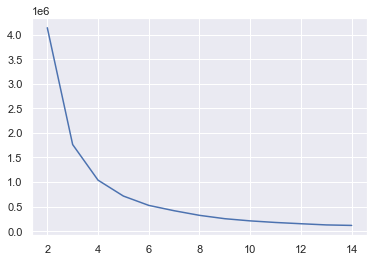

In [85]:
#the same strategy again
ssArray = []

for i in range(2,15):
    ssArray.append(cluster.k_means(np.array(data1.loc[data1["deliTime"] >= 0,"deliTime"]).reshape(-1,1),n_clusters=i)[2])
    
sns.lineplot(x=range(2,15),y=ssArray)
plt.show()

In [86]:
deliCluster = cluster.k_means(np.array(data1.loc[data1["deliTime"] >= 0,"deliTime"]).reshape(-1,1),n_clusters=4)
#only using values that were not marked as -300 or -5000


Now that we have clusters instead of ordinal values, we can transform the values into categories.

In [87]:
data1["deliCluster"] = "NA"
data1.loc[data1["deliTime"] >= 0,"deliCluster"] = deliCluster[1].astype(str)
data1.loc[data1["deliTime"] == -100,"deliCluster"] = "NA94"

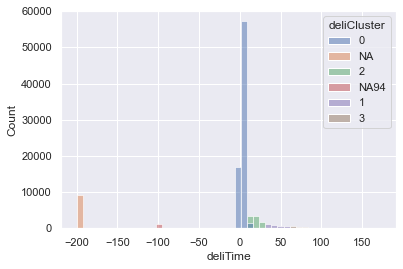

In [88]:
sns.histplot(data=data1,x="deliTime",bins=50,hue="deliCluster")
plt.show()

Looking at the crosstab of the "delicluster" and returns, and the histogram above, there seems to be a slight decrease in the number of returned items as the delivery times increase. The odd occurence is now labeled as NA94, and it implies a significantly lower return rate than the usual.

In [89]:
pd.crosstab(data1["deliCluster"],data1["return"]).apply(lambda x: x/sum(x),axis=1)

return,0,1
deliCluster,,
0,0.486262,0.513738
1,0.532057,0.467943
2,0.542957,0.457043
3,0.473011,0.526989
NA,1.000000,0.000000
NA94,0.624067,0.375933


The states from which the items were purchased, do not seem to have any significant information available (My aim was to merge the delivery time clusters with the bundesländer but some of the combinations did not occur in the unknown dataset and the juice did not seem to worth the squeeze, looking at the unpromising return ratios from the states).

In [90]:
#data1["deli_cluster"] = data1["user_state"].astype(str) + "&" + data1["deliCluster"].astype(str)
#data1.loc[data1["deli_cluster"].str.contains("NA$"),"deli_cluster"] = "NAX"
#data1.loc[data1["deli_cluster"].str.contains("NA94$"),"deli_cluster"] = "NA94"
pd.crosstab(data1["user_state"],data1["return"]).apply(lambda x: x/sum(x),axis=1)

return,0,1
user_state,,
Baden-Wuerttemberg,0.544445,0.455555
Bavaria,0.532475,0.467525
Berlin,0.537747,0.462253
Brandenburg,0.538324,0.461676
Bremen,0.583466,0.416534
Hamburg,0.564497,0.435503
Hesse,0.540469,0.459531
Lower Saxony,0.535349,0.464651
Mecklenburg-Western Pomerania,0.521341,0.478659


The same operations for the unknown dataset must take place:

In [91]:
data2["deliTime"] = (data2["delivery_date_formatted"]-data2["order_date_formatted"]).dt.days
data2.loc[data2["deliTime"] < - 5000,"deliTime"] = - 500
data2["deliTime"].fillna(-3000,inplace=True)


deliCluster2 = cluster.k_means(np.array(data2.loc[data2["deliTime"] >= 0,"deliTime"]).reshape(-1,1),n_clusters=4,init=deliCluster[0])


data2["deliCluster"] = "NA"
data2.loc[data2["deliTime"] >= 0,"deliCluster"] = deliCluster2[1].astype(str)
data2.loc[data2["deliTime"] == -500,"deliCluster"] = "NA94"

data2["deli_cluster"] = data2["user_state"].astype(str) + "&" + data2["deliCluster"]
data2.loc[data2["deli_cluster"].str.contains("NA$"),"deli_cluster"] = "NAX"
data2.loc[data2["deli_cluster"].str.contains("NA94$"),"deli_cluster"] = "NA94"



Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.


## Possible Reorders after Returns

Thinking about why a customer decides to return a purchase leads to quite a few possible explanations. Regarding the return decision not only as a one-off affair but one with temporal ramifications. The customer may still buy the same item again, this time by making a more informed decision. This could have an effect on the consecutive purchases of the same item by the user. Below is the procedure to investigate just that.

In [92]:
data1["week"] = data1["order_date_formatted"].dt.strftime("%V")
data1["day"] = data1["order_date_formatted"].dt.strftime("%j")

data1["key5"] = data1["user_id"].astype(str) + "&" + data1["item_id"].astype(str) + "&" + data1["week"] + "&" + data1["day"] 
#creating yet another unique key to group and aggregate the data
#we would like to see all the times a user buys the same item on different days.


reorders = data1.groupby("key5").agg(count=("key5","size")).reset_index() 

varNames_reorder = ["user_id","item_id","week","day"]



varHolder_reorder = reorders["key5"].apply(func = lambda x: x.split("&"))

for i in range(len(varNames_reorder)):
    reorders[varNames_reorder[i]] = varHolder_reorder.apply(lambda x: x[i]) #the same approach as before
    
#since we are only interested in the abovementioned combinations that occur more than once,
#we´ll need to filter the dataframe accordingly

reorders["key_sub"] = reorders["user_id"] + "&" + reorders["item_id"] 
reorders_sub = reorders.groupby("key_sub").agg(mult=("key_sub","size")).reset_index() #computing the combinations that occur more than once
reorders = reorders.merge(reorders_sub,how="left",on="key_sub") #merging the information back to the reorders df.
reorders_mult = reorders.loc[reorders["mult"] > 1,:] #filtering out the combinations that only occured once




In [93]:
def array_builder(x):
    return np.array(range(np.size(x)))+1 
#we would like to number the consecutive purchases. range() starts numbering from 0, hence the +1

reorder_mult2 = reorders_mult.groupby("key_sub").apply(len).to_frame("nice").reset_index()
#"nice" just represents the number of times each user&item combination occured on differnt days
#key_sub is the unique user&item key after aggregating the data according to calendar days

list_seq = np.array([]) #initialize the variable

for i in range(len(reorder_mult2["nice"])):
    list_seq = np.append(list_seq,np.array(range(reorder_mult2["nice"][i]))+1) 
    #sequentially number the occurances of the combinations stored in key_sub
    
    
reorders_mult = reorders_mult.assign(list_seq=list_seq) #the new variable
reorders_mult = reorders_mult.assign(key6 = reorders_mult["user_id"] + "&" + reorders_mult["item_id"] + "&" + reorders_mult["day"])
#unique key to merge the created variable back to the main dataset

In [94]:
reorders_mult
#to illustrate what this is about:
#the first time the user with id 10102 bought item 247 was on the 179th day.
#the second time occured on the 198th day.

,key5,count,user_id,item_id,week,day,key_sub,mult,list_seq,key6
133,10102&247&26&179,3,10102,247,26,179,10102&247,2,1.0,10102&247&179
134,10102&247&28&198,2,10102,247,28,198,10102&247,2,2.0,10102&247&198
139,10102&81&26&179,3,10102,81,26,179,10102&81,2,1.0,10102&81&179
140,10102&81&28&198,1,10102,81,28,198,10102&81,2,2.0,10102&81&198
160,10128&115&28&197,1,10128,115,28,197,10128&115,2,1.0,10128&115&197
...,...,...,...,...,...,...,...,...,...,...
81495,9952&1675&34&240,1,9952,1675,34,240,9952&1675,2,2.0,9952&1675&240
81521,9973&319&26&179,1,9973,319,26,179,9973&319,2,1.0,9973&319&179
81522,9973&319&28&194,1,9973,319,28,194,9973&319,2,2.0,9973&319&194
81535,998&1857&32&223,2,998,1857,32,223,998&1857,2,1.0,998&1857&223


In [95]:
data1["key6"] = data1["user_id"].astype(str) + "&" + data1["item_id"].astype(str) + "&" + data1["day"] #creating the same key in the main dataframe

data1 = data1.merge(reorders_mult[["key6","list_seq"]],how="left",on="key6") #left join operation

The observations that are outside the scope of this particular analyis are labeled with "0" (e.g. those combinations that only occured on a single day)

In [96]:
data1["list_seq"].fillna(0,inplace=True)
pd.concat([pd.crosstab(data1["list_seq"],data1["return"]),pd.crosstab(data1["list_seq"],data1["return"]).apply(lambda x: x/sum(x),axis=1)],axis=1)


return,0,1,0,1
list_seq,,,,
0.0,46345,39603,0.539221,0.460779
1.0,3377,3513,0.490131,0.509869
2.0,4001,2478,0.617534,0.382466
3.0,382,192,0.665505,0.334495
4.0,54,21,0.720000,0.280000
5.0,11,8,0.578947,0.421053
6.0,5,1,0.833333,0.166667
7.0,6,1,0.857143,0.142857
8.0,0,1,0.000000,1.000000


The evidence from the unknown dataset corroborates our assumption that a more informed decision would decrease the probability seeing a return on consecutive purchases. As I indicated above "0" represents the observations that do not fit within the scope of this particular analysis. Since there are so few observations corresponding to more than 4 occasions, I am merging them under the same category.

Now to make the final transformations to our features:

Both item prices and (surprisingly!) the average expenditure of customers seem to be heavily skewed. We can apply a log transformation followed by scaling of the features.

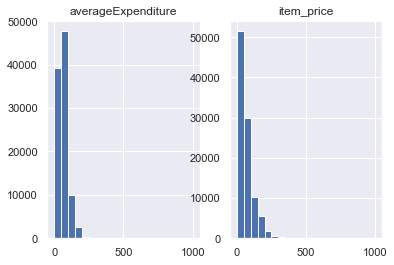

In [97]:
plt.subplot(1,2,1)

plt.hist(data1["averageExpenditure"],bins=20)
plt.title("averageExpenditure")

plt.subplot(1,2,2)
plt.hist(data1["item_price"],bins=20)
plt.title("item_price")
plt.show()

In [98]:
data1.loc[data1["list_seq"] > 4,"list_seq"] = 5


#to categorical
data1["list_seq"] = data1["list_seq"].astype("category")
data1["itemCluster"] = data1["itemCluster"].astype("category")
data1["ageCluster"] = data1["ageCluster"].astype("category")
data1["regCluster"] = data1["regCluster"].astype("category")
data1["deliCluster"] = data1["deliCluster"].astype("category")
data1["size_categoric"] = data1["size_categoric"].astype("category")
data1["user_title"] = data1["user_title"].astype("category")
data1["user_state"]= data1["user_state"].astype("category")

#scaling 

data1["averageExpenditure"] = scaling(np.log(1+data1["averageExpenditure"])) #average expenditure
data1["itemBasket_length"] = scaling(data1["itemBasket_length"]) #item basket size
data1["multFactor"] = scaling(data1["multFactor"]) #number of times an item appears in a given basket
data1["item_price_scaled"] = scaling(np.log(1+data1["item_price"])) #item prices




To create the same reorder-related variable for the unknown dataset, mostly the same operations are carried out below:

In [99]:
data2["week"] = data2["order_date_formatted"].dt.strftime("%V")
data2["day"] = data2["order_date_formatted"].dt.strftime("%j")

data2["key5"] = data2["user_id"].astype(str) + "&" + data2["item_id"].astype(str) + "&" + data2["week"] + "&" + data2["day"]



reorders2 = data2.groupby("key5").agg(count=("key5","size")).reset_index()

#varNames_reorder = ["user_id","item_id","week","day"]

varHolder_reorder_2 = reorders2["key5"].apply(func = lambda x: x.split("&"))



for i in range(len(varNames_reorder)):
    reorders2[varNames_reorder[i]] = varHolder_reorder_2.apply(lambda x: x[i])
    
reorders2["key_sub"] = reorders2["user_id"] + "&" + reorders2["item_id"]
reorders2_sub = reorders2.groupby("key_sub").agg(mult=("key_sub","size")).reset_index()
reorders2 = reorders2.merge(reorders2_sub,how="left",on="key_sub")
reorders2_mult = reorders2.loc[reorders2["mult"] > 1,:]



In [100]:
reorder2_mult2 = reorders2_mult.groupby("key_sub").apply(len).to_frame("nice").reset_index()

list_seq_2 = np.array([])

for i in range(len(reorder2_mult2["nice"])):
    list_seq_2 = np.append(list_seq_2,np.array(range(reorder2_mult2["nice"][i]))+1)
    
    
reorders2_mult = reorders2_mult.assign(list_seq=list_seq_2)
reorders2_mult = reorders2_mult.assign(key6 = reorders2_mult["user_id"] + "&" + reorders2_mult["item_id"] + "&" + reorders2_mult["day"]) 

In [101]:
data2["key6"] = data2["user_id"].astype(str) + "&" + data2["item_id"].astype(str) + "&" + data2["day"]

data2 = data2.merge(reorders2_mult[["key6","list_seq"]],how="left",on="key6")

data2["list_seq"].fillna(0,inplace=True)

In [102]:
data2.loc[data2["list_seq"] > 4,"list_seq"] = 5

data2["list_seq"] = data2["list_seq"].astype("category")
data2["itemCluster"] = data2["itemCluster"].astype("category")
data2["ageCluster"] = data2["ageCluster"].astype("category")
data2["regCluster"] = data2["regCluster"].astype("category")
data2["deliCluster"] = data2["deliCluster"].astype("category")
data2["size_categoric"] = data2["size_categoric"].astype("category")
data2["user_title"] = data2["user_title"].astype("category")
data2["user_state"]= data2["user_state"].astype("category")



In [103]:
data2["averageExpenditure"] = scaling(np.log(1+data2["averageExpenditure"]))
data2["itemBasket_length"] = scaling(data2["itemBasket_length"])
data2["multFactor"] = scaling(data2["multFactor"])
data2["item_price_scaled"] = scaling(np.log(1+data2["item_price"]))


Now that we have pretty much all the features we aimed for, a few more tweaks are left before we can move on to modeling.The behavior of the return ratio metric seem to be somewhat erratic in June and July, therefore I am introducing dummies to control for this behavior.

In [104]:
data1["month_count"] = data1["order_date_formatted"].dt.month
data1["isJune"] = data1["month_count"] == 6
data1["isJuly"] = data1["month_count"] == 7
data2["isJune"] = False
data2["isJuly"] = False

After the transformation, the item price related features now have nicer distributions.

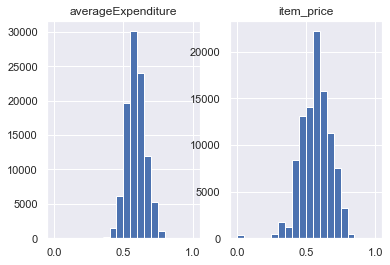

In [105]:
plt.subplot(1,2,1)

plt.hist(data1["averageExpenditure"],bins=20)
plt.title("averageExpenditure")

plt.subplot(1,2,2)
plt.hist(data1["item_price_scaled"],bins=20)
plt.title("item_price")
plt.show()

# Model Selection - Model Tuning

Under this section, I will be preparing and tuning three models for our prediction task. To make predictions on a binary response variable the following models provide suitable toolkits: Logistic Regression, Random Forest and XGBoost. Considering our features like the ratios, the models run a danger of overfitting to the training data. For that very reason, any metric we use to select or evaluate the models may produce an overly optimistic outcome.

The dataframe below stores all the relevant exogenous features and will be the basis for further analysis.

In [106]:
data1_reg = data1[["itemCluster","user_title","user_state","isJune","isJuly","itemRatio","itemCheck","item_count_scaled","item_price_scaled","isFirstPurchase","ageCluster","userRatio","user_count_scaled","averageExpenditure","regCluster","size_categoric","itemBasket_length","multFactor","deliCluster","list_seq","brandRatio"]]

After running some tests I am convinced that weight of evidence modeling instead of using one-hot-encoded dummies for categorical variables is more accurate for this occasion.

In [107]:




#WoE 
cat_vars = data1_reg.select_dtypes(include="category").columns
woe_model = WOEEncoder(cat_vars).fit(data1_reg, data1["return"])
data1_reg = woe_model.fit_transform(data1_reg, data1["return"])





is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [108]:
data1_reg

,itemCluster,user_title,user_state,isJune,isJuly,itemRatio,itemCheck,item_count_scaled,item_price_scaled,isFirstPurchase,...,userRatio,user_count_scaled,averageExpenditure,regCluster,size_categoric,itemBasket_length,multFactor,deliCluster,list_seq,brandRatio
0,-1.349006,0.006552,0.074234,True,False,0.181818,True,0.444580,0.568906,True,...,0.500000,0.212712,0.491162,-0.052103,0.104069,0.016949,0.000000,0.222629,0.010460,0.355346
1,-1.349006,0.006552,0.074234,True,False,0.096154,True,0.568301,0.440395,True,...,0.500000,0.212712,0.491162,-0.052103,0.104069,0.016949,0.000000,-8.972146,0.010460,0.355346
2,0.446526,0.006552,-0.010557,True,False,0.506173,True,0.632047,0.635983,True,...,0.588235,0.548564,0.542355,0.060844,-0.114750,0.135593,0.000000,0.222629,0.010460,0.538950
3,0.446526,0.006552,-0.010557,True,False,0.535088,True,0.780894,0.667964,True,...,0.588235,0.548564,0.542355,0.060844,-0.114750,0.135593,0.000000,0.222629,0.010460,0.538950
4,-0.567286,0.006552,-0.010557,True,False,0.386861,True,0.707633,0.400466,True,...,0.588235,0.548564,0.542355,0.060844,-0.114750,0.135593,0.000000,0.222629,0.010460,0.366582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.446526,0.006552,-0.003247,False,False,0.502262,True,0.776409,0.496653,False,...,0.500000,0.268413,0.496653,0.060844,0.104069,0.016949,0.041667,0.222629,-0.311274,0.498771
99996,0.446526,0.006552,-0.003247,False,False,0.502262,True,0.776409,0.496653,False,...,0.500000,0.268413,0.496653,0.060844,0.104069,0.016949,0.041667,0.222629,-0.311274,0.498771
99997,0.446526,-0.141645,-0.091562,False,False,0.448980,True,0.659449,0.481868,False,...,0.500000,0.212712,0.486966,-0.067433,-0.114750,0.016949,0.041667,-0.338198,-0.311274,0.431086
99998,0.446526,-0.141645,-0.091562,False,False,0.448980,True,0.659449,0.481868,False,...,0.500000,0.212712,0.486966,-0.067433,-0.114750,0.016949,0.041667,-0.338198,-0.311274,0.431086


Keeping 80% of the dataset as the training set and the rest as the test set has proven to be useful. 

In [109]:
index_train = np.random.choice([False, True], len(data1_reg), p=[0.8, 0.2])
index_train = np.array([not i for i in index_train])


In [110]:
#splitting the data into train and test

data_train = data1_reg.loc[index_train,:]
data_test = data1_reg.loc[~index_train,:]

response_train = data1.loc[index_train,"return"]
response_test = data1.loc[~index_train,"return"]


Now that we have all the features we wanted to create, we can use the information gain approach to assess the promise of our features.

In [111]:
from sklearn.feature_selection import mutual_info_classif

imps = mutual_info_classif(data_train,response_train) 


<AxesSubplot:>

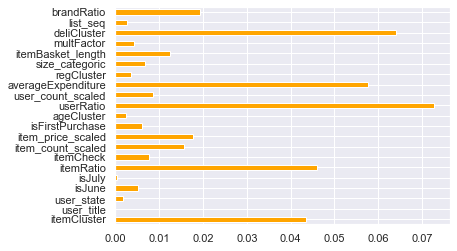

In [112]:
imps = pd.Series(imps,data_train.columns)
imps.plot(kind="barh",color="orange")


The information gain chart above shows that only a few of our features have been assessed to be unimportant. 

## Logistic Regression

Below is the application of a logistic regression from two different sources. The summary function supplied by the statmodels package is going to be useful in observing the preliminary effectiveness of the engineered features. On the other hand, because we have tailored a set of highly promising features and we do not actually want them being set to zero, I will only be using the ridge regression approach to regularize the logistic regression model.

First, let us look at how our features are evaluated by a simple logistic regression fit to the training data.

In [113]:
logit_model_2 = sm.Logit(response_train,sm.add_constant(data1_reg.loc[index_train,:].astype("float"))).fit()

Optimization terminated successfully.
         Current function value: 0.520528
         Iterations 12


In [114]:
print(logit_model_2.summary())

                           Logit Regression Results                           
Dep. Variable:                 return   No. Observations:                79979
Model:                          Logit   Df Residuals:                    79957
Method:                           MLE   Df Model:                           21
Date:                Fri, 30 Apr 2021   Pseudo R-squ.:                  0.2453
Time:                        00:14:48   Log-Likelihood:                -41631.
converged:                       True   LL-Null:                       -55161.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -4.5813      0.168    -27.259      0.000      -4.911      -4.252
itemCluster            0.2438      0.020     12.288      0.000       0.205       0.283
user_title          

Although we are not primarily interested in the significance of the features, it is still worthwhile taking a look at the result. Keeping mind that this is a logistic regression using heavily transformed variables, the interpretation of the regression coefficients is not straightforward. Especially those that have been transformed to weight of evidence features are quite difficult to interpret.

It is still nice to see that, with a few exceptions, our set of features seem not so bad at explaining the variation in the response variable. There are some contrasts to be seen with the information gain plot just above. Some of the seemingly insignificant features according to the logistic regression output seem to have some degree of importance when assessed by the information approach. Because we are getting mixed signals and becaue I believe the set of features are complementaries to each other and that logistic regression and the other methods I will be using are fundamentally different in how they approach the features, I won´t be eliminating any variables, even those variables that are not "significant" or "unimportant" might prove to be useful in the context of an other method.

In [115]:
auc_holder = []

for i in np.linspace(0.1,3,10):
    logit_model = LogisticRegression(solver='sag',random_state=0,C=i,max_iter=1000).fit(data_train,response_train)
    prob = logit_model.predict_proba(data_test)
    prob_arr = np.array(list(map(lambda x: x[1], prob)))
    a, b, c = metrics.roc_curve(response_test,prob_arr)
    roc_auc = metrics.auc(a, b)
    roc_auc
    auc_holder.append(roc_auc)

In [116]:
pd.DataFrame({"lambda_values":1/np.linspace(0.1,3,10),"auc_values":auc_holder})

,lambda_values,auc_values
0,10.000000,0.809972
1,2.368421,0.810260
2,1.343284,0.810285
3,0.937500,0.810293
4,0.720000,0.810296
5,0.584416,0.810298
6,0.491803,0.810300
7,0.424528,0.810302
8,0.373444,0.810302
9,0.333333,0.810303


It seems, the AUC values corresponding to the lambda values (the inverse C value in the function) seems to peak at lambda=1.34. (Values change depending on the choice of train/test set indices, the final values might not reflect the comment I wrote at the time.)

In [117]:
logit_model = LogisticRegression(solver='sag',random_state=0,C=np.linspace(0.1,3,10)[2],max_iter=1000).fit(data_train,response_train)
prob = logit_model.predict_proba(data_test)
prob_arr = np.array(list(map(lambda x: x[1], prob)))
a, b, c = metrics.roc_curve(response_test,prob_arr)
roc_auc_logit = metrics.auc(a, b)
roc_auc_logit

0.810284899061911

## Random Forest

Next we build a random forest classifier on our training data, and report the the performance using the testing data. I will tune the model based on tree depth and maximum number of features to consider. 

In [119]:
rf = RandomForestClassifier(random_state=888, max_samples = 0.5)

In [137]:
rf_params_grid = {'max_depth': np.linspace(7, 10, 4),
              'max_features': [9,10,11]
              }

# Set up the grid object specifying the tuning options
grid_rf = GridSearchCV(rf, rf_params_grid, cv=5, scoring='roc_auc', verbose=1)
grid_rf.fit(data1_reg,data1["return"])

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  6.4min finished


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=8, max_features=10,
                                              max_samples=0.5,
                                              random_state=888),
             param_grid={'max_depth': array([ 7.,  8.,  9., 10.]),
                         'max_features': [9, 10, 11]},
             scoring='roc_auc', verbose=1)

In [121]:
#rf.set_params(**grid_rf.best_params_)
rf.set_params(**{"max_depth":8,"max_features":10})
rf.fit(data_train,response_train)



RandomForestClassifier(max_depth=8, max_features=10, max_samples=0.5,
                       random_state=888)

In [122]:
rf_pred = pd.DataFrame(rf.predict_proba(data_test))
rf_pred.rename(columns={0: "x", 1: "y"},inplace=True)

In [123]:

a, b, c = metrics.roc_curve(response_test,rf_pred["y"])
roc_auc_rf = metrics.auc(a, b)
roc_auc_rf



0.8123260089812778

## XGBoost

Last but not the least, we are going to take a look at the XGBoost algorithm. 

### Tuning

Tuning the XGBoost algorithm takes quite a while. For tuning the parameters I use two sources: first is the GridSearch interfrace from sklearn, the second is the tuning functionality of the hyperopt package. Although I provide the functions and the procedure that I used to tune the algorithm, the final choice of parameters come from tens of runs attempts both at tuning and on Kaggle. My primary goal in tuning the parameters is to avoid overfitting. That is why I tried to assign higher alpha and gamma values. 

In [157]:
#parameters for sklearn gridsearch
xgb_reg_params = {
    'subsample' : [0.9],
    'colsample_bytree': [0.8],
    'n_estimators': [100], 
    'max_depth': [3,4,5,6,7,8],   
    "gamma": [10],
    "alpha": [10],
    'learning_rate': [0.1]
    } 


grid_xgb = GridSearchCV(estimator=xgb.XGBClassifier(use_label_encoder=False), param_grid=xgb_reg_params, scoring='roc_auc', cv=5, verbose=10)
grid_xgb.fit(data1_reg,data1["return"])

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] alpha=10, colsample_bytree=0.8, gamma=10, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.9 
[11:35:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  alpha=10, colsample_bytree=0.8, gamma=10, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.9, score=0.836, total=   1.1s
[CV] alpha=10, colsample_bytree=0.8, gamma=10, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.9 
[11:35:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV]  alpha=10, colsample_bytree=0.8, gamma=10, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.9, score=0.802, total=   1.2s
[CV] alpha=10, colsample_bytree=0.8, gamma=10, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.9 
[11:35:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s


[CV]  alpha=10, colsample_bytree=0.8, gamma=10, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.9, score=0.760, total=   1.2s
[CV] alpha=10, colsample_bytree=0.8, gamma=10, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.9 
[11:35:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.4s remaining:    0.0s


[CV]  alpha=10, colsample_bytree=0.8, gamma=10, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.9, score=0.798, total=   1.2s
[CV] alpha=10, colsample_bytree=0.8, gamma=10, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.9 
[11:35:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.6s remaining:    0.0s


[CV]  alpha=10, colsample_bytree=0.8, gamma=10, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.9, score=0.799, total=   1.2s
[CV] alpha=10, colsample_bytree=0.8, gamma=10, learning_rate=0.1, max_depth=4, n_estimators=100, subsample=0.9 
[11:35:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.8s remaining:    0.0s


[CV]  alpha=10, colsample_bytree=0.8, gamma=10, learning_rate=0.1, max_depth=4, n_estimators=100, subsample=0.9, score=0.835, total=   1.4s
[CV] alpha=10, colsample_bytree=0.8, gamma=10, learning_rate=0.1, max_depth=4, n_estimators=100, subsample=0.9 
[11:35:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    7.2s remaining:    0.0s


[CV]  alpha=10, colsample_bytree=0.8, gamma=10, learning_rate=0.1, max_depth=4, n_estimators=100, subsample=0.9, score=0.799, total=   1.4s
[CV] alpha=10, colsample_bytree=0.8, gamma=10, learning_rate=0.1, max_depth=4, n_estimators=100, subsample=0.9 
[11:35:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    8.6s remaining:    0.0s


[CV]  alpha=10, colsample_bytree=0.8, gamma=10, learning_rate=0.1, max_depth=4, n_estimators=100, subsample=0.9, score=0.756, total=   1.4s
[CV] alpha=10, colsample_bytree=0.8, gamma=10, learning_rate=0.1, max_depth=4, n_estimators=100, subsample=0.9 
[11:35:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   10.0s remaining:    0.0s


[CV]  alpha=10, colsample_bytree=0.8, gamma=10, learning_rate=0.1, max_depth=4, n_estimators=100, subsample=0.9, score=0.800, total=   1.5s
[CV] alpha=10, colsample_bytree=0.8, gamma=10, learning_rate=0.1, max_depth=4, n_estimators=100, subsample=0.9 
[11:35:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   11.5s remaining:    0.0s


[CV]  alpha=10, colsample_bytree=0.8, gamma=10, learning_rate=0.1, max_depth=4, n_estimators=100, subsample=0.9, score=0.801, total=   1.6s
[CV] alpha=10, colsample_bytree=0.8, gamma=10, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.9 
[11:35:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  alpha=10, colsample_bytree=0.8, gamma=10, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.9, score=0.827, total=   1.9s
[CV] alpha=10, colsample_bytree=0.8, gamma=10, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.9 
[11:35:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'bi

[CV]  alpha=10, colsample_bytree=0.8, gamma=10, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.9, score=0.802, total=   2.1s
[CV] alpha=10, colsample_bytree=0.8, gamma=10, learning_rate=0.1, max_depth=8, n_estimators=100, subsample=0.9 
[11:35:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  alpha=10, colsample_bytree=0.8, gamma=10, learning_rate=0.1, max_depth=8, n_estimators=100, subsample=0.9, score=0.803, total=   2.4s
[CV] alpha=10, colsample_bytree=0.8, gamma=10, learning_rate=0.1, max_depth=8, n_estimators=100, subsample=0.9 
[11:35:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'bi

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   54.3s finished


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, us

In [158]:
grid_xgb.best_params_

{'alpha': 10,
 'colsample_bytree': 0.8,
 'gamma': 10,
 'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 100,
 'subsample': 0.9}

Although these seem the be the best parameters in the given search space. The performance of these metrics have not been very convincing on the unknown dataset.

In [162]:
#setting the grid for hyperopt
xgb_reg_params = {
    'learning_rate':    0.1,
    'max_depth':        hp.hp.choice("max_depth", np.arange(3, 8, 1, dtype=int)),
    'colsample_bytree': 0.8,
    'subsample':        0.9,
    "gamma": 10,
    'n_estimators':     1000,
}
xgb_fit_params = {
    'eval_metric': 'auc',
    'early_stopping_rounds': 50,
    'verbose': False
}
xgb_para = dict()
xgb_para['reg_params'] = xgb_reg_params
xgb_para['fit_params'] = xgb_fit_params
xgb_para['loss_func' ] = lambda y, pred : np.sqrt(metrics.mean_squared_error(y, pred))



Tuning using the hyperopt package happens in the following manner. Here we create the HPopt class to deal with the tuning in a more organized manner. The class hosts the means to store the test and training data, iterate them according to the combinations of the parameters and report the results.

In [163]:
class HPOpt(object): #initiate a class

    def __init__(self, x_train, x_test, y_train, y_test): # constructor, stores the partition of the data
        self.x_train = x_train
        self.x_test  = x_test
        self.y_train = y_train
        self.y_test  = y_test

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try: #try-catch structure to report any possible error
            result = hp.fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials) #minimization of the loss function
        except Exception as e:
            return {'status': hp.STATUS_FAIL,
                    'exception': str(e)}
        return result, trials

    
    def xgb_class(self, para): #function for the xgboost classifier
        reg = xgb.XGBClassifier(**para['reg_params'],use_label_encoder=False)
        return self.train_reg(reg, para)


    def train_reg(self, reg, para): #report the attempt
        reg.fit(self.x_train, self.y_train,
                eval_set=[(self.x_train, self.y_train), (self.x_test, self.y_test)],
                **para['fit_params'])
        pred = reg.predict(self.x_test)
        loss = para['loss_func'](self.y_test, pred)
        return {'loss': loss, 'status': hp.STATUS_OK}

In [164]:
#create an instance of the HPOpt class, 
obj = HPOpt(data1_reg.loc[index_train,:],data1_reg.loc[~index_train,:], data1.loc[index_train,"return"], data1.loc[~index_train,"return"])

In [165]:
#tuning happens here
xgb_opt = obj.process(fn_name='xgb_class', space=xgb_para, trials=hp.Trials(), algo=hp.tpe.suggest, max_evals=100)

100%|██████████| 100/100 [22:44<00:00, 13.64s/trial, best loss: 0.5184826006762887]


In [166]:
xgb_opt

({'max_depth': 3}, <hyperopt.base.Trials at 0x195e1cb1a00>)

Same disclaimer as above applies here as well. Because the dataset with the engineered features is very prone to overfitting, the tuned parameters are not necessarily the best option for making predictions on the unknown dataset.

In [124]:
data_matrix_train  = xgb.DMatrix(data=data_train,label=response_train)
data_matrix_test  = xgb.DMatrix(data=data_test,label=response_test)

In [125]:
xgb_params = {
    "objective": "binary:logistic",
    "eta": 0.01,
    "num_class": 1,
    "max_depth": 4,
    "colsample_bytree":0.8,
    "subsample":0.9,
    "gamma":10,
    "alpha": 10,
    "eval_metric":"auc"
    
}


evallist  = [(data_matrix_train,'train'),(data_matrix_test,'eval')]

gbdt = xgb.train(xgb_params,data_matrix_train,num_boost_round=20000,evals=evallist,early_stopping_rounds=50)

[0]	train-auc:0.72545	eval-auc:0.73581
[1]	train-auc:0.72931	eval-auc:0.74015
[2]	train-auc:0.77189	eval-auc:0.78039
[3]	train-auc:0.76439	eval-auc:0.77309
[4]	train-auc:0.77862	eval-auc:0.78584
[5]	train-auc:0.78344	eval-auc:0.79005
[6]	train-auc:0.78591	eval-auc:0.79217
[7]	train-auc:0.78732	eval-auc:0.79329
[8]	train-auc:0.78670	eval-auc:0.79363
[9]	train-auc:0.78769	eval-auc:0.79438
[10]	train-auc:0.78847	eval-auc:0.79494
[11]	train-auc:0.79130	eval-auc:0.79716
[12]	train-auc:0.79127	eval-auc:0.79730
[13]	train-auc:0.79181	eval-auc:0.79766
[14]	train-auc:0.79222	eval-auc:0.79784
[15]	train-auc:0.79199	eval-auc:0.79779
[16]	train-auc:0.79222	eval-auc:0.79783
[17]	train-auc:0.79248	eval-auc:0.79800
[18]	train-auc:0.79251	eval-auc:0.79799
[19]	train-auc:0.79253	eval-auc:0.79802
[20]	train-auc:0.79266	eval-auc:0.79805
[21]	train-auc:0.79236	eval-auc:0.79792
[22]	train-auc:0.79255	eval-auc:0.79808
[23]	train-auc:0.79255	eval-auc:0.79805
[24]	train-auc:0.79253	eval-auc:0.79806
[25]	train

[203]	train-auc:0.80244	eval-auc:0.80713
[204]	train-auc:0.80244	eval-auc:0.80714
[205]	train-auc:0.80247	eval-auc:0.80716
[206]	train-auc:0.80254	eval-auc:0.80721
[207]	train-auc:0.80260	eval-auc:0.80726
[208]	train-auc:0.80264	eval-auc:0.80727
[209]	train-auc:0.80273	eval-auc:0.80738
[210]	train-auc:0.80279	eval-auc:0.80744
[211]	train-auc:0.80287	eval-auc:0.80752
[212]	train-auc:0.80286	eval-auc:0.80750
[213]	train-auc:0.80295	eval-auc:0.80758
[214]	train-auc:0.80298	eval-auc:0.80759
[215]	train-auc:0.80297	eval-auc:0.80759
[216]	train-auc:0.80301	eval-auc:0.80761
[217]	train-auc:0.80310	eval-auc:0.80768
[218]	train-auc:0.80315	eval-auc:0.80775
[219]	train-auc:0.80315	eval-auc:0.80775
[220]	train-auc:0.80321	eval-auc:0.80777
[221]	train-auc:0.80325	eval-auc:0.80780
[222]	train-auc:0.80331	eval-auc:0.80785
[223]	train-auc:0.80329	eval-auc:0.80785
[224]	train-auc:0.80333	eval-auc:0.80787
[225]	train-auc:0.80339	eval-auc:0.80789
[226]	train-auc:0.80342	eval-auc:0.80792
[227]	train-auc:

[403]	train-auc:0.80825	eval-auc:0.81172
[404]	train-auc:0.80826	eval-auc:0.81172
[405]	train-auc:0.80827	eval-auc:0.81172
[406]	train-auc:0.80829	eval-auc:0.81174
[407]	train-auc:0.80831	eval-auc:0.81175
[408]	train-auc:0.80833	eval-auc:0.81177
[409]	train-auc:0.80834	eval-auc:0.81178
[410]	train-auc:0.80836	eval-auc:0.81179
[411]	train-auc:0.80838	eval-auc:0.81182
[412]	train-auc:0.80841	eval-auc:0.81185
[413]	train-auc:0.80843	eval-auc:0.81186
[414]	train-auc:0.80843	eval-auc:0.81186
[415]	train-auc:0.80844	eval-auc:0.81187
[416]	train-auc:0.80846	eval-auc:0.81189
[417]	train-auc:0.80848	eval-auc:0.81191
[418]	train-auc:0.80850	eval-auc:0.81193
[419]	train-auc:0.80852	eval-auc:0.81195
[420]	train-auc:0.80853	eval-auc:0.81195
[421]	train-auc:0.80857	eval-auc:0.81199
[422]	train-auc:0.80860	eval-auc:0.81202
[423]	train-auc:0.80862	eval-auc:0.81203
[424]	train-auc:0.80864	eval-auc:0.81204
[425]	train-auc:0.80865	eval-auc:0.81205
[426]	train-auc:0.80867	eval-auc:0.81206
[427]	train-auc:

[603]	train-auc:0.81186	eval-auc:0.81453
[604]	train-auc:0.81187	eval-auc:0.81454
[605]	train-auc:0.81188	eval-auc:0.81454
[606]	train-auc:0.81190	eval-auc:0.81455
[607]	train-auc:0.81191	eval-auc:0.81455
[608]	train-auc:0.81193	eval-auc:0.81457
[609]	train-auc:0.81194	eval-auc:0.81458
[610]	train-auc:0.81194	eval-auc:0.81458
[611]	train-auc:0.81195	eval-auc:0.81458
[612]	train-auc:0.81198	eval-auc:0.81460
[613]	train-auc:0.81199	eval-auc:0.81460
[614]	train-auc:0.81202	eval-auc:0.81461
[615]	train-auc:0.81202	eval-auc:0.81461
[616]	train-auc:0.81203	eval-auc:0.81462
[617]	train-auc:0.81204	eval-auc:0.81463
[618]	train-auc:0.81205	eval-auc:0.81463
[619]	train-auc:0.81206	eval-auc:0.81464
[620]	train-auc:0.81207	eval-auc:0.81465
[621]	train-auc:0.81209	eval-auc:0.81466
[622]	train-auc:0.81210	eval-auc:0.81467
[623]	train-auc:0.81214	eval-auc:0.81469
[624]	train-auc:0.81214	eval-auc:0.81470
[625]	train-auc:0.81216	eval-auc:0.81471
[626]	train-auc:0.81217	eval-auc:0.81472
[627]	train-auc:

[803]	train-auc:0.81396	eval-auc:0.81599
[804]	train-auc:0.81396	eval-auc:0.81600
[805]	train-auc:0.81397	eval-auc:0.81600
[806]	train-auc:0.81397	eval-auc:0.81600
[807]	train-auc:0.81397	eval-auc:0.81600
[808]	train-auc:0.81398	eval-auc:0.81600
[809]	train-auc:0.81398	eval-auc:0.81600
[810]	train-auc:0.81399	eval-auc:0.81601
[811]	train-auc:0.81400	eval-auc:0.81602
[812]	train-auc:0.81401	eval-auc:0.81603
[813]	train-auc:0.81402	eval-auc:0.81603
[814]	train-auc:0.81403	eval-auc:0.81604
[815]	train-auc:0.81404	eval-auc:0.81605
[816]	train-auc:0.81404	eval-auc:0.81606
[817]	train-auc:0.81405	eval-auc:0.81606
[818]	train-auc:0.81406	eval-auc:0.81607
[819]	train-auc:0.81408	eval-auc:0.81608
[820]	train-auc:0.81409	eval-auc:0.81608
[821]	train-auc:0.81409	eval-auc:0.81609
[822]	train-auc:0.81410	eval-auc:0.81609
[823]	train-auc:0.81413	eval-auc:0.81611
[824]	train-auc:0.81414	eval-auc:0.81612
[825]	train-auc:0.81415	eval-auc:0.81612
[826]	train-auc:0.81415	eval-auc:0.81612
[827]	train-auc:

[1003]	train-auc:0.81506	eval-auc:0.81670
[1004]	train-auc:0.81507	eval-auc:0.81670
[1005]	train-auc:0.81507	eval-auc:0.81670
[1006]	train-auc:0.81507	eval-auc:0.81670
[1007]	train-auc:0.81508	eval-auc:0.81670
[1008]	train-auc:0.81508	eval-auc:0.81670
[1009]	train-auc:0.81508	eval-auc:0.81670
[1010]	train-auc:0.81509	eval-auc:0.81670
[1011]	train-auc:0.81509	eval-auc:0.81670
[1012]	train-auc:0.81509	eval-auc:0.81670
[1013]	train-auc:0.81509	eval-auc:0.81670
[1014]	train-auc:0.81509	eval-auc:0.81670
[1015]	train-auc:0.81510	eval-auc:0.81671
[1016]	train-auc:0.81511	eval-auc:0.81671
[1017]	train-auc:0.81511	eval-auc:0.81671
[1018]	train-auc:0.81511	eval-auc:0.81671
[1019]	train-auc:0.81511	eval-auc:0.81671
[1020]	train-auc:0.81511	eval-auc:0.81671
[1021]	train-auc:0.81511	eval-auc:0.81671
[1022]	train-auc:0.81512	eval-auc:0.81671
[1023]	train-auc:0.81512	eval-auc:0.81671
[1024]	train-auc:0.81512	eval-auc:0.81671
[1025]	train-auc:0.81512	eval-auc:0.81671
[1026]	train-auc:0.81512	eval-auc:

[1199]	train-auc:0.81551	eval-auc:0.81697
[1200]	train-auc:0.81551	eval-auc:0.81697
[1201]	train-auc:0.81552	eval-auc:0.81697
[1202]	train-auc:0.81552	eval-auc:0.81697
[1203]	train-auc:0.81552	eval-auc:0.81697
[1204]	train-auc:0.81552	eval-auc:0.81697
[1205]	train-auc:0.81552	eval-auc:0.81697
[1206]	train-auc:0.81552	eval-auc:0.81697
[1207]	train-auc:0.81552	eval-auc:0.81697
[1208]	train-auc:0.81552	eval-auc:0.81697
[1209]	train-auc:0.81552	eval-auc:0.81697
[1210]	train-auc:0.81553	eval-auc:0.81697
[1211]	train-auc:0.81553	eval-auc:0.81697
[1212]	train-auc:0.81553	eval-auc:0.81697
[1213]	train-auc:0.81553	eval-auc:0.81697
[1214]	train-auc:0.81553	eval-auc:0.81697
[1215]	train-auc:0.81554	eval-auc:0.81697
[1216]	train-auc:0.81554	eval-auc:0.81697
[1217]	train-auc:0.81554	eval-auc:0.81697
[1218]	train-auc:0.81554	eval-auc:0.81697
[1219]	train-auc:0.81554	eval-auc:0.81697
[1220]	train-auc:0.81554	eval-auc:0.81697
[1221]	train-auc:0.81555	eval-auc:0.81698
[1222]	train-auc:0.81555	eval-auc:

[1395]	train-auc:0.81575	eval-auc:0.81709
[1396]	train-auc:0.81575	eval-auc:0.81709
[1397]	train-auc:0.81576	eval-auc:0.81710
[1398]	train-auc:0.81576	eval-auc:0.81710
[1399]	train-auc:0.81576	eval-auc:0.81710
[1400]	train-auc:0.81576	eval-auc:0.81710
[1401]	train-auc:0.81576	eval-auc:0.81710
[1402]	train-auc:0.81576	eval-auc:0.81710
[1403]	train-auc:0.81576	eval-auc:0.81710
[1404]	train-auc:0.81576	eval-auc:0.81710
[1405]	train-auc:0.81576	eval-auc:0.81710
[1406]	train-auc:0.81576	eval-auc:0.81710
[1407]	train-auc:0.81576	eval-auc:0.81710
[1408]	train-auc:0.81576	eval-auc:0.81710
[1409]	train-auc:0.81576	eval-auc:0.81710
[1410]	train-auc:0.81576	eval-auc:0.81710
[1411]	train-auc:0.81576	eval-auc:0.81710
[1412]	train-auc:0.81576	eval-auc:0.81710
[1413]	train-auc:0.81576	eval-auc:0.81710
[1414]	train-auc:0.81578	eval-auc:0.81711
[1415]	train-auc:0.81579	eval-auc:0.81711
[1416]	train-auc:0.81579	eval-auc:0.81711
[1417]	train-auc:0.81579	eval-auc:0.81711
[1418]	train-auc:0.81579	eval-auc:

[1591]	train-auc:0.81595	eval-auc:0.81721
[1592]	train-auc:0.81595	eval-auc:0.81721
[1593]	train-auc:0.81595	eval-auc:0.81721
[1594]	train-auc:0.81595	eval-auc:0.81721
[1595]	train-auc:0.81595	eval-auc:0.81721
[1596]	train-auc:0.81595	eval-auc:0.81721
[1597]	train-auc:0.81595	eval-auc:0.81721
[1598]	train-auc:0.81595	eval-auc:0.81721
[1599]	train-auc:0.81595	eval-auc:0.81721
[1600]	train-auc:0.81595	eval-auc:0.81721
[1601]	train-auc:0.81595	eval-auc:0.81721
[1602]	train-auc:0.81595	eval-auc:0.81721
[1603]	train-auc:0.81595	eval-auc:0.81721
[1604]	train-auc:0.81595	eval-auc:0.81721
[1605]	train-auc:0.81595	eval-auc:0.81721
[1606]	train-auc:0.81595	eval-auc:0.81721
[1607]	train-auc:0.81595	eval-auc:0.81721
[1608]	train-auc:0.81595	eval-auc:0.81721
[1609]	train-auc:0.81595	eval-auc:0.81721
[1610]	train-auc:0.81595	eval-auc:0.81721
[1611]	train-auc:0.81595	eval-auc:0.81721
[1612]	train-auc:0.81595	eval-auc:0.81721
[1613]	train-auc:0.81595	eval-auc:0.81721
[1614]	train-auc:0.81595	eval-auc:

[1787]	train-auc:0.81604	eval-auc:0.81726
[1788]	train-auc:0.81604	eval-auc:0.81726
[1789]	train-auc:0.81604	eval-auc:0.81726
[1790]	train-auc:0.81604	eval-auc:0.81726
[1791]	train-auc:0.81604	eval-auc:0.81726
[1792]	train-auc:0.81604	eval-auc:0.81726
[1793]	train-auc:0.81604	eval-auc:0.81726
[1794]	train-auc:0.81604	eval-auc:0.81726
[1795]	train-auc:0.81604	eval-auc:0.81726
[1796]	train-auc:0.81605	eval-auc:0.81727
[1797]	train-auc:0.81605	eval-auc:0.81727
[1798]	train-auc:0.81605	eval-auc:0.81727
[1799]	train-auc:0.81605	eval-auc:0.81727
[1800]	train-auc:0.81605	eval-auc:0.81727
[1801]	train-auc:0.81605	eval-auc:0.81727
[1802]	train-auc:0.81605	eval-auc:0.81727
[1803]	train-auc:0.81605	eval-auc:0.81727
[1804]	train-auc:0.81606	eval-auc:0.81727
[1805]	train-auc:0.81606	eval-auc:0.81727
[1806]	train-auc:0.81606	eval-auc:0.81727
[1807]	train-auc:0.81606	eval-auc:0.81727
[1808]	train-auc:0.81606	eval-auc:0.81727
[1809]	train-auc:0.81606	eval-auc:0.81727
[1810]	train-auc:0.81606	eval-auc:

In [126]:
gbdt.best_score

0.817281

In [127]:
print("Logistic Regression Test AUC:",roc_auc_logit )
print("Random Forest Test AUC:",roc_auc_rf)
print("XGBoost Test AUC:",gbdt.best_score)

Logistic Regression Test AUC: 0.810284899061911
Random Forest Test AUC: 0.8123260089812778
XGBoost Test AUC: 0.817281


It seems XGBoost is significantly better compared to the alternatives. For predictive purposes, I will be using XGBoost from now on.

# Model Evaluation

The prediction task features a special objective: Minimize the return and opportunity costs by making the most suitable prediction. This means that the performance metric for evaluating the model is not necessarily one of the traditional metrics like the AUC. XGBoost gives us the opportunity to set our own performance metric. 

## Cost-Sensitive Learning

The custom performance metric takes into account the incurred costs from false negatives and positives. Below is a solution to take advantage of the custom performance metric feature in XGBoost. I produced the cutoff value using the following reasoning:

- I needed to look at the ratio of returns in the dataset, because there is no danger in assuming that both the known and the unknown datasets come from the same data generating process. 

- 54.2/45.8 appears to be the non-return/return ratio.
-  We can therefore make a rough estimation, using the prediction value that falls on the 54.2 percentile of all predictions.

In [144]:
np.percentile(gbdt.predict(xgb.DMatrix(data1_reg,data1["return"])),54.18)

0.4999618574380874

The functions below compute and report the item-price dependent costs of false negative and false positives, in a manner which is compatible with the xgboost algorithm.

In [129]:
item_prices = data1["item_price"]
from typing import Tuple
def cost_calculator(tpl): #using the zip method results in an iterable collection of tuples
    pred = tpl[0]
    real = tpl[1] #unpack the tuple
    price = tpl[2]
    
    if(pred > 0.499): #cutoff is introduced here
        pred = 1
    else:
        pred = 0
    
    if(pred == real): #no costs incurred if the prediction is correct
        return 0
    elif(pred > real): #if it is a false positive, opportunity costs occur
        return 0.5*price
    else:
        return 0.5*5*(3 + 0.1*price) #false negative implies a return and therefore shipment costs
    

    
def cost_performance(predt : np.ndarray, dtrain: xgb.DMatrix) -> Tuple[str, float]: #takes in an array and xgboost structure, 
    #returns a tuple
    #create a suitable function for the xgboost algorithm.
    
    y = dtrain.get_label() 
    
    item_price_train = item_prices[index_train] #use the global variable that stores the item prices
    item_price_test = item_prices[~index_train]
    
 
    if(len(item_price_train) == dtrain.num_row()): #is the function called to calculate for the test or the train set?
        pri_array = list(item_price_train)
        
    else:
        pri_array = list(item_price_test)
        
            
    out_array = list(map(cost_calculator,zip(predt,y,pri_array))) #call the cost calculator,after creating an iterable by zip.
        
    
    return "total_cost", sum(out_array) #tuple is returned

Now that we´re set, we can use our model of choice, XGBoost with tuned parameters and the custom cost performance metric.

In [135]:
xgb_params = {
    "objective": "binary:logistic",
    "eta": 0.01,
    "num_class": 1,
    "max_depth": 4,
    "colsample_bytree":0.8,
    "subsample":0.9,
    "gamma":10,
    "alpha": 10,
    "disable_default_eval_metric":True #required to suppress the default eval metric
    
}


evallist  = [(data_matrix_train,'train'),(data_matrix_test,'eval')]

gbdt_cost = xgb.train(xgb_params,data_matrix_train,num_boost_round=20000,evals=evallist,early_stopping_rounds=100,feval=cost_performance)

[0]	train-total_cost:938450.57500	eval-total_cost:234208.97750
[1]	train-total_cost:938450.57500	eval-total_cost:234208.97750
[2]	train-total_cost:938450.57500	eval-total_cost:234208.97750
[3]	train-total_cost:938450.57500	eval-total_cost:234208.97750
[4]	train-total_cost:938450.57500	eval-total_cost:234208.97750
[5]	train-total_cost:938450.57500	eval-total_cost:234208.97750
[6]	train-total_cost:938450.57500	eval-total_cost:234208.97750
[7]	train-total_cost:938450.57500	eval-total_cost:234208.97750
[8]	train-total_cost:938450.57500	eval-total_cost:234208.97750
[9]	train-total_cost:938450.57500	eval-total_cost:234208.97750
[10]	train-total_cost:938450.57500	eval-total_cost:234208.97750
[11]	train-total_cost:938450.57500	eval-total_cost:234208.97750
[12]	train-total_cost:938450.57500	eval-total_cost:234208.97750
[13]	train-total_cost:938450.57500	eval-total_cost:234208.97750
[14]	train-total_cost:938450.57500	eval-total_cost:234208.97750
[15]	train-total_cost:938450.57500	eval-total_cost

[128]	train-total_cost:740479.50000	eval-total_cost:186978.48250
[129]	train-total_cost:741878.95000	eval-total_cost:187195.49500
[130]	train-total_cost:739934.22500	eval-total_cost:186921.20750
[131]	train-total_cost:739462.58750	eval-total_cost:186836.95750
[132]	train-total_cost:739350.90000	eval-total_cost:186683.49500
[133]	train-total_cost:738582.62500	eval-total_cost:186631.07000
[134]	train-total_cost:738530.02500	eval-total_cost:186578.59500
[135]	train-total_cost:738632.35000	eval-total_cost:186604.84500
[136]	train-total_cost:736901.02500	eval-total_cost:186006.62000
[137]	train-total_cost:735931.45000	eval-total_cost:185895.47000
[138]	train-total_cost:735191.58000	eval-total_cost:185701.09500
[139]	train-total_cost:734692.13000	eval-total_cost:185476.25750
[140]	train-total_cost:734786.84250	eval-total_cost:185369.23250
[141]	train-total_cost:733841.21750	eval-total_cost:185223.75750
[142]	train-total_cost:733622.88000	eval-total_cost:185063.90750
[143]	train-total_cost:73

[255]	train-total_cost:673175.66750	eval-total_cost:170476.45500
[256]	train-total_cost:672131.23250	eval-total_cost:170474.03000
[257]	train-total_cost:673343.99500	eval-total_cost:170370.34250
[258]	train-total_cost:671755.10750	eval-total_cost:170305.24250
[259]	train-total_cost:671450.15750	eval-total_cost:170268.96750
[260]	train-total_cost:671256.37000	eval-total_cost:170346.33000
[261]	train-total_cost:671115.45750	eval-total_cost:170283.88000
[262]	train-total_cost:670705.25500	eval-total_cost:170325.50500
[263]	train-total_cost:670343.20500	eval-total_cost:170202.36750
[264]	train-total_cost:670044.84250	eval-total_cost:170078.69250
[265]	train-total_cost:670072.89250	eval-total_cost:170081.14250
[266]	train-total_cost:669992.93000	eval-total_cost:169951.21750
[267]	train-total_cost:669530.03000	eval-total_cost:169933.30500
[268]	train-total_cost:669364.48000	eval-total_cost:170010.75500
[269]	train-total_cost:669103.96750	eval-total_cost:169979.23000
[270]	train-total_cost:66

[382]	train-total_cost:655408.98000	eval-total_cost:166713.58000
[383]	train-total_cost:655234.25500	eval-total_cost:166591.14250
[384]	train-total_cost:654833.14250	eval-total_cost:166551.61750
[385]	train-total_cost:654727.49250	eval-total_cost:166551.61750
[386]	train-total_cost:654619.21750	eval-total_cost:166529.14250
[387]	train-total_cost:654614.86750	eval-total_cost:166572.01750
[388]	train-total_cost:654476.38000	eval-total_cost:166501.69250
[389]	train-total_cost:654532.30500	eval-total_cost:166464.24250
[390]	train-total_cost:654313.51750	eval-total_cost:166371.24250
[391]	train-total_cost:654090.36750	eval-total_cost:166138.61750
[392]	train-total_cost:654014.86750	eval-total_cost:165939.36750
[393]	train-total_cost:654246.81750	eval-total_cost:166131.66750
[394]	train-total_cost:653941.56750	eval-total_cost:165882.29250
[395]	train-total_cost:654121.39250	eval-total_cost:165777.36750
[396]	train-total_cost:654387.31750	eval-total_cost:165657.44250
[397]	train-total_cost:65

[509]	train-total_cost:647404.35500	eval-total_cost:162617.58250
[510]	train-total_cost:647228.29250	eval-total_cost:162607.10750
[511]	train-total_cost:647264.50500	eval-total_cost:162629.58250
[512]	train-total_cost:647285.89250	eval-total_cost:162677.08250
[513]	train-total_cost:647041.33000	eval-total_cost:162617.13250
[514]	train-total_cost:646937.43000	eval-total_cost:162574.63250
[515]	train-total_cost:646911.13000	eval-total_cost:162547.15750
[516]	train-total_cost:646898.75500	eval-total_cost:162528.45750
[517]	train-total_cost:646806.49250	eval-total_cost:162381.25750
[518]	train-total_cost:646704.19250	eval-total_cost:162553.65750
[519]	train-total_cost:646694.20500	eval-total_cost:162373.60750
[520]	train-total_cost:646716.64250	eval-total_cost:162351.13250
[521]	train-total_cost:646488.06750	eval-total_cost:162338.65750
[522]	train-total_cost:646084.70500	eval-total_cost:162383.63250
[523]	train-total_cost:646084.70500	eval-total_cost:162371.15750
[524]	train-total_cost:64

[636]	train-total_cost:641215.06750	eval-total_cost:160778.94500
[637]	train-total_cost:641247.51750	eval-total_cost:160768.94500
[638]	train-total_cost:641293.99250	eval-total_cost:160733.44500
[639]	train-total_cost:641250.29250	eval-total_cost:160680.97000
[640]	train-total_cost:641300.16750	eval-total_cost:160749.19500
[641]	train-total_cost:641110.25500	eval-total_cost:160674.23250
[642]	train-total_cost:640975.30500	eval-total_cost:160674.23250
[643]	train-total_cost:640947.80500	eval-total_cost:160604.27000
[644]	train-total_cost:640668.15500	eval-total_cost:160629.27000
[645]	train-total_cost:640668.15500	eval-total_cost:160629.27000
[646]	train-total_cost:640935.40500	eval-total_cost:160629.27000
[647]	train-total_cost:640642.68000	eval-total_cost:160659.97000
[648]	train-total_cost:640696.75500	eval-total_cost:160684.14500
[649]	train-total_cost:640615.83000	eval-total_cost:160720.37000
[650]	train-total_cost:640585.90500	eval-total_cost:160822.79500
[651]	train-total_cost:64

[763]	train-total_cost:638901.43000	eval-total_cost:159635.20750
[764]	train-total_cost:638702.86750	eval-total_cost:159525.25750
[765]	train-total_cost:638871.39250	eval-total_cost:159623.35750
[766]	train-total_cost:638871.39250	eval-total_cost:159623.35750
[767]	train-total_cost:638946.34250	eval-total_cost:159623.35750
[768]	train-total_cost:638738.90500	eval-total_cost:159629.50750
[769]	train-total_cost:638663.83000	eval-total_cost:159619.53250
[770]	train-total_cost:638532.65500	eval-total_cost:159621.28250
[771]	train-total_cost:638580.05500	eval-total_cost:159637.50750
[772]	train-total_cost:638540.00500	eval-total_cost:159652.50750
[773]	train-total_cost:638354.05500	eval-total_cost:159581.28250
[774]	train-total_cost:638468.80500	eval-total_cost:159556.33250
[775]	train-total_cost:638491.30500	eval-total_cost:159595.03250
[776]	train-total_cost:638383.93000	eval-total_cost:159607.48250
[777]	train-total_cost:638436.40500	eval-total_cost:159632.45750
[778]	train-total_cost:63

It is worth looking at other sources that offer cost-sensitive learning functionalities. The costcla package has several such solutions for the cost-sensitive learning problem. First we are going to construct our cost matrix that contains all the possible cost values that can incur in the case that one of the 4 possible outcomes occur. I regard these models as benchmarks to our more emphasized models.

In [130]:
cost_matrix = pd.DataFrame(item_prices)
cost_matrix["false_positive"] = cost_matrix["item_price"]*0.5
cost_matrix["false_negative"] =  0.5*5*(3 + 0.1*cost_matrix["item_price"])
cost_matrix["true_positive"] = 0
cost_matrix["true_negative"] = 0
cost_matrix.drop("item_price",inplace=True,axis=1)

cost_matrix_train = cost_matrix[index_train]
cost_matrix_test = cost_matrix[~index_train]

cost_matrix.to_numpy()

array([[24.95  , 19.975 ,  0.    ,  0.    ],
       [ 9.975 , 12.4875,  0.    ,  0.    ],
       [39.95  , 27.475 ,  0.    ,  0.    ],
       ...,
       [13.45  , 14.225 ,  0.    ,  0.    ],
       [13.45  , 14.225 ,  0.    ,  0.    ],
       [13.95  , 14.475 ,  0.    ,  0.    ]])

First of the two methods I will be employing here is the Bayes Minimum Risk Classifier. It is a model agnostic method that takes the probability predictions of the true label and gives us the cost-sensitive minimum risk classifier predictions. I will be using the output of the "vanilla" XGBoost model to construct BMR predictions.

In [149]:
bmr = BayesMinimumRiskClassifier()
bmr.fit(data_matrix_test.get_label(),pd.DataFrame({"a":gbdt.predict(data_matrix_test),"b":1-gbdt.predict(data_matrix_test)}).to_numpy())

In [157]:
bmr_test_pred = bmr.predict(pd.DataFrame({"a":gbdt.predict(data_matrix_test),"b":1-gbdt.predict(data_matrix_test)}).to_numpy(),cost_matrix_test.to_numpy())

The next is the Cost Sensitive Decision Tree Classifier:

In [171]:

from costcla.models import CostSensitiveDecisionTreeClassifier

csdt = CostSensitiveDecisionTreeClassifier()
csdt.fit(data_train.to_numpy(),response_train.to_numpy(),cost_matrix_train.to_numpy())

CostSensitiveDecisionTreeClassifier()

The cost that are associated to the predictions of the Bayes Minimum Risk and the Cost-Sensitive Decision Tree models are summarized below.

In [176]:
print("bayes minimum risk test set costs:",sum(list(map(cost_calculator,zip(bmr_test_pred,response_test,item_prices[~index_train])))))

print("cost-sensitive decision tree test set costs:",sum(list(map(cost_calculator,zip(csdt.predict(data_test.to_numpy()),response_test,item_prices[~index_train])))))




bayes minimum risk test set costs: 238114.3825000278
cost-sensitive decision tree test set costs: 172598.91250001252


In [136]:
print("logistic regression test set costs:",sum(list(map(cost_calculator,zip(prob_arr,response_test,item_prices[~index_train])))))

print("random forest test set costs:", sum(list(map(cost_calculator,zip(rf_pred["y"],response_test,item_prices[~index_train])))))

print("xgboost test set costs:", sum(list(map(cost_calculator,zip(gbdt_cost.predict(data_matrix_test),response_test,item_prices[~index_train])))))


logistic regression test set costs: 168942.0250000079
random forest test set costs: 167165.0450000076
xgboost test set costs: 163363.51500000688


It seems, the xgboost model (with cost-sensitive evaluation metric) is vastly superior to the other alternatives. Therefore our choice of the model is justified.

Although it is in the domain of interpretable machine learning, the feature importance functionality from xgboost is helpful in evaluating the outcome of the model at hand (It is also helpful to see if you are overfitting your model, in this case, I know that if the model is too dependent on one of the potentially overfitting features, e.g. userRatio, then I know that the unknown dataset performance is not going to be spectacular as well). Comparing the cost-sensitive learning outcome to the auc-sensitive learning outcome shows that two models used slightly different setups.

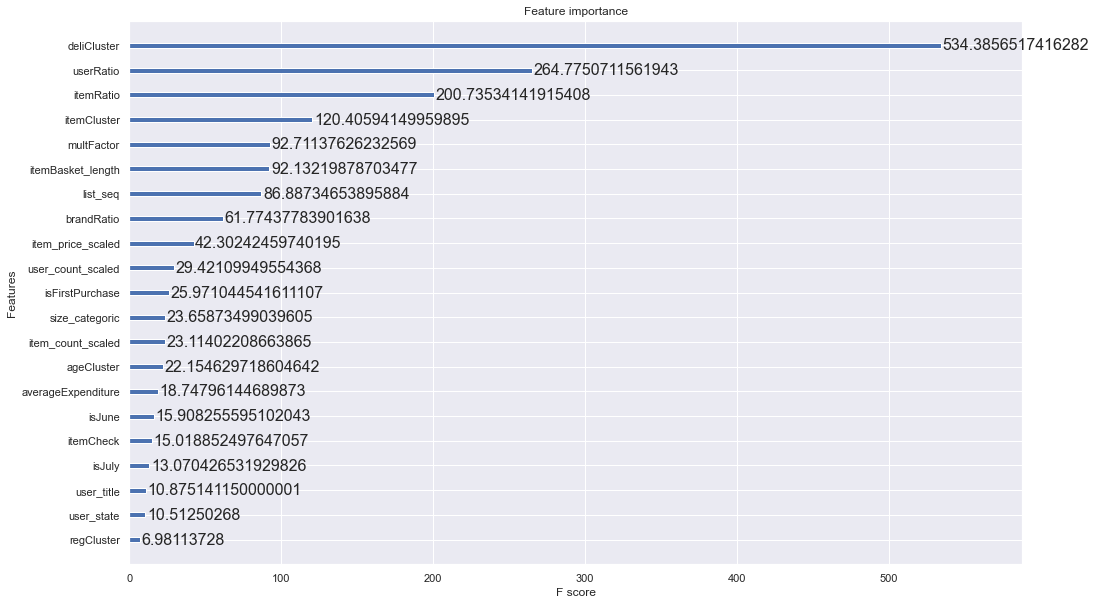

In [127]:
xgb.plot_importance(gbdt_cost,importance_type="gain")

plt.rcParams['font.size'] = '16'
plt.rcParams['figure.figsize'] = (16,10)
plt.show()


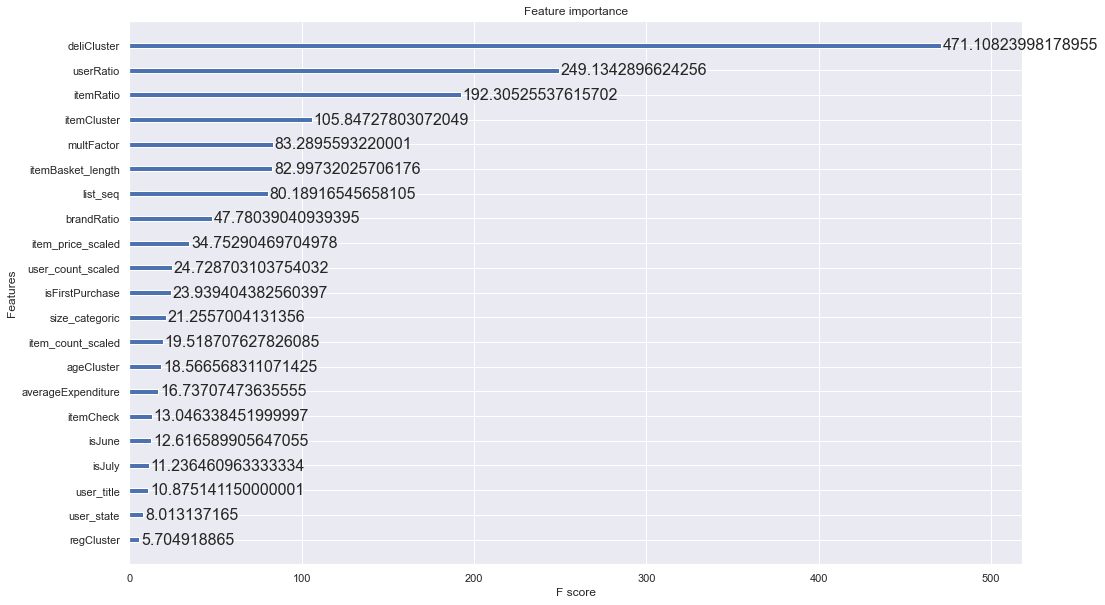

In [128]:
xgb.plot_importance(gbdt,importance_type="gain")

plt.rcParams['font.size'] = '16'
plt.rcParams['figure.figsize'] = (16,10)
plt.show()


One step left until we can finally generate our predictions for the unknown dataset. We need to transfer the WoE - IV values we have already established for the known dataset to the unknown dataset.

In [129]:
data2["item_price_scaled"] = scaling(np.log(1+data2["item_price"]))


In [131]:
data2_reg = data2[["itemCluster","user_title","user_state","isJune","isJuly","itemRatio","itemCheck","item_count_scaled","item_price_scaled","isFirstPurchase","ageCluster","userRatio","user_count_scaled","averageExpenditure","regCluster","size_categoric","itemBasket_length","multFactor","deliCluster","list_seq","brandRatio"]]

In [132]:
#the lines below assigns the woe values computed for the known dataset to the suitable recipients in the unknown dataset
#this is not actually an elegant solution, because the woe package in python, for some reason, 
#does not have any method to print out both the names of the categories and the corresponding woe values
#which would have made the entire procedure much easier and more reliable.

data2_reg["deliCluster"] = data2_reg["deliCluster"].replace(pd.unique(data1["deliCluster"]),woe_model.mapping.get("deliCluster").iloc[range(len(pd.unique(data1["deliCluster"])))])
data2_reg["ageCluster"] = data2_reg["ageCluster"].replace(pd.unique(data1["ageCluster"]),pd.unique(data1_reg["ageCluster"]))
data2_reg["size_categoric"] = data2_reg["size_categoric"].replace(pd.unique(data1["size_categoric"]),pd.unique(data1_reg["size_categoric"]))
data2_reg["regCluster"] = data2_reg["regCluster"].replace(pd.unique(data1["regCluster"]),pd.unique(data1_reg["regCluster"]))
data2_reg["list_seq"] = data2_reg["list_seq"].replace(pd.unique(data1["list_seq"]),pd.unique(data1_reg["list_seq"]))  
data2_reg["itemCluster"] = data2_reg["itemCluster"].replace(pd.unique(data1["itemCluster"]),pd.unique(data1_reg["itemCluster"]))
data2_reg["user_title"] = data2_reg["user_title"].replace(pd.unique(data1["user_title"]),pd.unique(data1_reg["user_title"]))  
data2_reg["user_state"] = data2_reg["user_state"].replace(pd.unique(data1["user_state"]),pd.unique(data1_reg["user_state"]))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

Because the itemCluster feature depends on the return ratios, it is not possible to create it on the unknown dataset. After the join operations, the items that are new to the unknown dataset got NA as the itemCluster value. We know that we have transformed this feature into a weight of evidence feature. Replacing the NA values with 0 will equal to not providing any information about this specific case.

In [133]:
data2_reg["itemCluster"].fillna(0,inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [134]:
data2_reg = data2_reg[data1_reg.columns] #columns must be in the same order as the training dataset

In [145]:
preds = gbdt_cost.predict(xgb.DMatrix(data2_reg))

We know that a missing delivery date is equivalent to a non-return:

In [146]:
preds[data2["delivery_date"].isna()] = 0

In [147]:
pred_frame = pd.DataFrame({"order_item_id":order_id_unknown,"return":preds})
pred_frame["return"] = pred_frame["return"]>0.499
pred_frame["return"] = pred_frame["return"].astype(int)
pred_frame





,order_item_id,return
0,100001,1
1,100002,1
2,100003,1
3,100004,1
4,100005,1
...,...,...
49995,149996,1
49996,149997,0
49997,149998,1
49998,149999,0


Everything seems to be in order, we can save this as the predictions file.

In [148]:
pred_frame.to_csv("205284.csv",index=False)

## Interpretability
Under this section, I will be discussing Shapley Additive Explanations (SHAP) and Anchors for machine learning interpretability. While SHAP provides means to work with XGBoost output, other packages for interpretability methods do not seem to have the same feature. For that reason, I will be using the Random Forest output for producing anchors.

### SHAP
SHAP calculates the contributions of each feature to each prediction instance. When these contributions are aggregated over the entire dataset, we get the most important features in fitting the model.

In [131]:
#using the functions from the SHAP package to construct the SHAP explanations
exp = sp.Explainer(gbdt)
ee = exp(data1_reg)

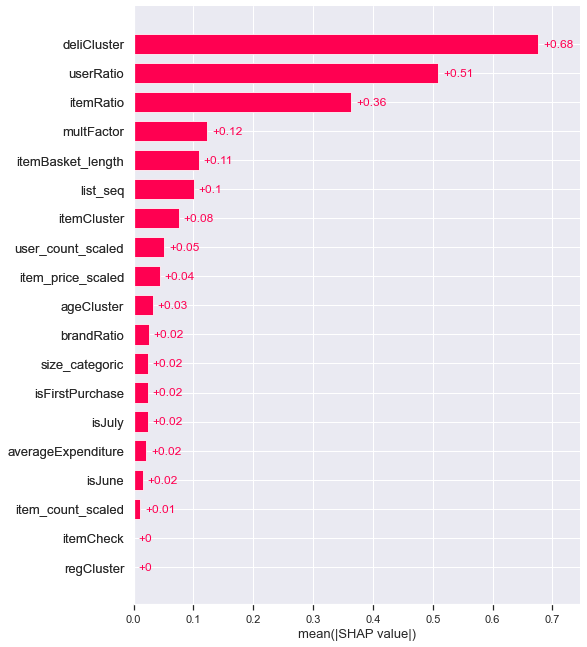

In [212]:
sp.plots.bar(ee,max_display=30)

The SHAP importance plot is pretty similar to the native importance plot in the xgboost package. A quick glance to the plot reveals what we expected all along. The deliCluster feature is a very strong predictor. This is mostly because it contains categories for missing and weird delivery dates. The user and item related ratios follow the delivery feature. As I stated previously, these two features are potentially overfitting sources. 

Seeing them below the delivery feature is good news. We can tell that the model has been somewhat conservative in incorporating these variables in its predictions. The rest of the variables are more interesting. The features I engineered seem to have meaningfully contributed to the model. The case in which an item appears along a multiple of itself in the same basket seem to carry some weight for a return decision, in the end.

In addition, the size of the basket, and the consecutive purchases of the same item by the same user seem to play a significant role. Even though the remaining features do not seem to be as important as the abovementioned features, as a whole they make the fourth greatest contribution among the set of features.

Looking at the beeswarm plot below, one of the shortcomings of the set of features becomes apparent. The features are not directly interpretable due to the transformations they have gone through. Red points with a greater (in number) SHAP values represent the values of a feature that seem to increase the chances that we see a returned item. We can directly recognize the SHAP values that correspond to the NA values in the delivery dates column: a long blue line on the deliCluster row.

Although it is not very easy to interpret categorical variables after doing WoE transformation (One would need to simultaneously look at the mapping WoE transformation creates), we can see that almost all the variables behave as expected.

It is worth noting that, even though some variables were found to be insignificant by the logistic regression run I did (e.g. item_basket_length). It has found it way to among the contributing features in the XGBoost model! This is a very interesting result and displays the power of the XGBoost algorithm. Among the features judged to be unimportant by the information gain approach, only itemCheck and the RegCluster features seem to have a non-existent effect on the model.

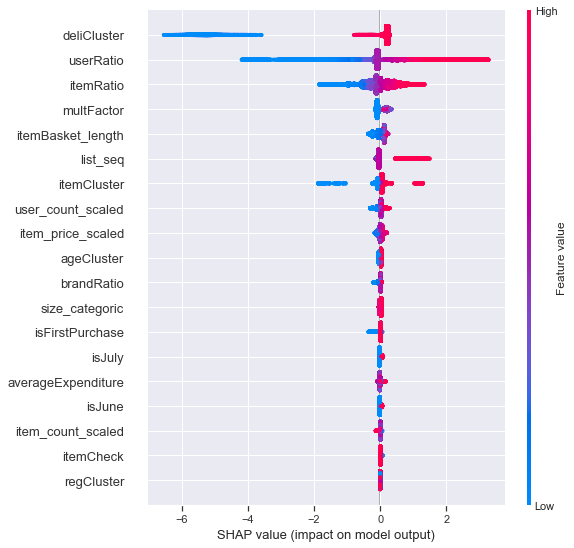

In [213]:
sp.plots.beeswarm(ee,max_display=30)

The list_seq feature seems especially interesting.

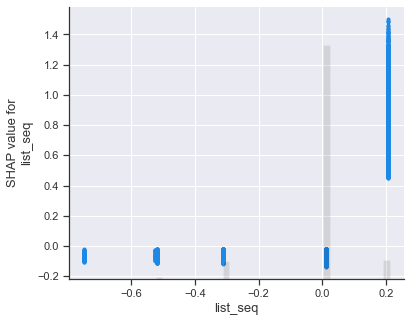

In [214]:
sp.plots.scatter(ee[:,"list_seq"])

In [215]:
pd.DataFrame({"list_seq":pd.unique(data1["list_seq"]),"woe":woe_model.mapping.get("list_seq")[0:6]})

,list_seq,woe
list_seq,,
1,0.0,0.010460
2,1.0,0.207136
3,2.0,-0.311274
4,3.0,-0.517680
5,4.0,-0.748626
6,5.0,-0.525482


Looking at the two figures above, we can see that the neutral list_seq value 0 has pretty much a nonexistant effect on the model. First purchase of an item in a series of purchases by the same user, however, seem to have an incresed likelihood for return. 

On the other hand, sadly, the second purchase, that was supposed to significantly indicate a lower likelihood for returns, only has a minimal negative effect.

We are now about to investigate 4 possible outcome cases using force plots (Assuming a cutoff of 0.5).

In [216]:
df_demo = pd.DataFrame({"user_id":data1["user_id"],"item_id":data1["item_id"],"prediction":gbdt.predict(xgb.DMatrix(data1_reg,data1["return"])),"reality":data1["return"]})
df_demo.iloc[[1,2,3,99989],:]

,user_id,item_id,prediction,reality
1,30822,337,0.001494,0
2,30823,270,0.676689,1
3,30823,142,0.703113,0
99989,12130,1806,0.272263,1


#### True Negative

In [217]:
sp.initjs()
sp.plots.force(ee[1])

This is one of the cases where we can observe the missing delivery value at work. The "force" this value imposes on the prediction is so strong that it is enough to bring to a non-return prediction just by itself. The occasion also features a very low itemRatio, which can also be seen pushing the prediction to the non-return zone.

#### True Positive

In [218]:
sp.plots.force(ee[2])

The case is a true positive and we can see several contributing factors in that decision. Although there is some opposing force from other features, the tug of war is won by the "return" camp, decisively. Even a userRatio of 0.58 was a very strong predictor in this case.

#### False Positive

In [219]:
sp.plots.force(ee[3])

The case is strikingly similar to the true positive case. But it is a false positive! The set of engineered features do not seem to provide enough information to label this case correctly. These two items were bought by the same user within the same basket. Quite a few of our features revolve around these ideas, so it is no surprise that it cannot distinguish between return and non-return in this case. 

#### False Negative

In [220]:
sp.plots.force(ee[99989])

There is actually some contention in this case. The evidence from a 30%~ itemRatio seem to be too strong for the model to label this as a positive.

### Anchors

I will be using the output of the random forest model to build a few anchors, because the available packages currently do not support XGBoost output (Even though Anchors is a model-agnostic method for interpreting black-box models only using data). Anchor is quite a fitting name for this method because it provides us with some rules that are robust to perturbations in other variables. Meaning, no matter what happens to the remaining variables, the prediction stays the same. 

In [132]:
predict_fn = lambda x: rf.predict(x)
explainer = al.explainers.AnchorTabular(predict_fn, data1_reg.columns) #anchor explanations for tabular data

In [133]:
#fitting the explainer to our data and predictions
explainer.fit(data1_reg.to_numpy(),disc_perc=[25, 50, 75]) #requires the input to be a matrix, not as a pandas dataframe

AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {'seed': None, 'disc_perc': [25, 50, 75]}}
)

In [134]:
prob_rf = rf.predict_proba(data1_reg)
prob_rf = np.array(list(map(lambda x: x[1], prob_rf)))


df_demo = pd.DataFrame({"user_id":data1["user_id"],"item_id":data1["item_id"],"prediction":prob_rf,"reality":data1["return"]})
df_demo.iloc[[1,2,3,99989],:]

,user_id,item_id,prediction,reality
1,30822,337,0.001535,0
2,30823,270,0.673588,1
3,30823,142,0.691362,0
99989,12130,1806,0.272323,1


#### True Negative

In [135]:
rf_exp = explainer.explain(data1_reg.to_numpy()[1,:],threshold=1)
rf_exp.anchor

['itemRatio <= 0.36',
 'user_count_scaled <= 0.27',
 'item_price_scaled <= 0.50',
 'list_seq <= 0.01']

For some reason, the Anchors method does not seem to capture the missing delivery value belonging to this particular observation (SHAP was quite good at this!). The transformations the features have gone through comes up as yet another obstacle in this occasion. Nevertheless, it still gives us some insights: Because the observation´s item ratio is below 0.36, the user is among the users that makes rather infrequent purchases compared to other customers, and (by looking at the table above that explains the list_seq values) the user has not purchased this item for a second time, the Random Forest model have chosen to predict a very low probability for this item´s return. Correctly.

#### True Positive

In [136]:
rf_exp = explainer.explain(data1_reg.to_numpy()[2,:],threshold=1)
rf_exp.anchor

['userRatio > 0.50',
 'itemRatio > 0.47',
 'size_categoric <= -0.02',
 'regCluster > 0.01']

Another shortcoming of Anchors is that it cannot give us how much a specific rule impacts the given prediction decision. SHAP provides this in the form of force values. Here, the method gives us quite a few rules (setting the threshold to 1 helps this too), making it more difficult to interpret. But we can see a pattern here, the ratio features seem to be contributing very significantly to the prediction decisions.

#### False Positive

In [129]:
rf_exp = explainer.explain(data1_reg.to_numpy()[3,:],threshold=1)
rf_exp.anchor

['userRatio > 0.50',
 'itemRatio > 0.47',
 'itemCluster > -0.07',
 'multFactor <= 0.00',
 'size_categoric <= -0.02',
 'deliCluster <= 0.22',
 'ageCluster > -0.10']

As discussed above, the True Positive case and the False Positive case feature very similar observations and point at one of  the inherent difficulties in prediction tasks: Noise! How can we even distinguish between ostensibly same observations?

#### False Negative

In [127]:
rf_exp = explainer.explain(data1_reg.to_numpy()[99989,:],threshold=1)
rf_exp.anchor

['itemRatio <= 0.36',
 'userRatio <= 0.50',
 'itemCluster <= -0.57',
 'list_seq <= 0.01']

According to the model, the evidence here is quite convincing to label the observation as a non-return, incorrectly! Of course, it is because we do not have, as I discussed above, a reliable metric with a high coverage that predicts non-returns. Perhaps interpretation of the machine learning models can tells us where to focus while engineering the features at hand. I for one used the importance plot found in the xgboost package to a great extent to guide my feature selection decisions. But that alone does not tell us how each feature affects the prediction decisions. Other interpretation methods may shed light on other aspects as well.

# Conclusions

Perhaps fittingly, the overwhelming majority of the time I spent on this task has been on creating, testing and engineering features. If I put the unprocessed dataset directly into one of the algorithms I discussed, given that it worked, it would still give us a prediction: possibly with a much lower accuracy than what the processed data gives us. This shows us why data science practicioners put the emphasis on feature engineering.

The case I discussed in this specific report, is a mere representation of how impactful it can be to employ well-balanced state-of-the-art methods to improve enterprise performance. But it also shows that, sometimes it might be better to stop and focus on something else and that law of diminishing returns is at work here too! While engineering features, tuning and selecting the models seem like the right thing to do, their contributions seem to have decreasing returns.

Still, with enough time and skill put on the feature engineering department, even a very basic method like logistic regression may provide superior results compared to its more powerful counterparts with weaker feature engineering input. Although it may be called "machine learning" it is still the human behind the machine that provides it with the input, experience and human ingenuity.





